Dissertation
    
# **Notebook 5: Clustering Ascending LSOAs**
    
This notebook will cluster identified ascending LSOAs to identify gentrifying LSOAs. Code adapted from https://github.com/jytg17/Unpacking-the-Nuances-of-Londons-Neighbourhood-Change-Gentrification-Trajectories-codes 
***

In [58]:
# Load packages

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar

In [59]:
# Look at working dir

print("The working directory is " + os.getcwd())

The working directory is /home/jovyan/work/OneDrive/UCL/Dissertation/Notebooks V3


In [60]:
shapefiles = os.path.join("Shapefiles")

profiles = os.path.join("LSOA Profiles")

clean = os.path.join("Cleaned data")

nc = os.path.join("Data", "Now-Casting")

In [61]:
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

# 1. Read in data

In [62]:
level1 = gpd.read_file(os.path.join(clean, "level1.shp"))

In [63]:
census_2001 = pd.read_csv(os.path.join(profiles, "census_2001_profile.csv"))
census_2011 = pd.read_csv(os.path.join(profiles, "census_2011_profile.csv"))

# 2. 2001 Data

In [64]:
# Filter

census_2001_filt = census_2001[["LSOA01CD", 'Age 65 to 74', 'Age 75 to 84', 'Age 85 to 89', 'Age 90 and over', 
                               'One family and no others - cohabiting couple households - no children', 'One family and no others - married couple households - no children',
                                'One family and no others - married couple households - with dependent children', 'One family and no others - cohabiting couple households - with dependent children',
                                        'One family and no others - Lone parent households - with dependent children', 'Other households - With dependent children',
                                'One family and no others - married couple households - all children non-dependent', 
                                                  'One family and no others - cohabiting couple households - all children non-dependent',
                                                 'One family and no others - Lone parent households - all children non-dependent',
                                "One person household - Pensioner", 'Other households - All pensioner',
                                'All usual residents', 
                                
                                
                               ]]

In [65]:
# Change numeric types

census_2001_filt.iloc[:, 1:] = census_2001_filt.iloc[:, 1:].apply(pd.to_numeric)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [66]:
# Calculate

census_2001_cluster = census_2001_filt[["LSOA01CD"]]
census_2001_cluster["residents_above_65"] = census_2001_filt[['Age 65 to 74', 'Age 75 to 84', 'Age 85 to 89', 'Age 90 and over']].sum(axis=1)
census_2001_cluster["no_children"] =  census_2001_filt[['One family and no others - cohabiting couple households - no children', 'One family and no others - married couple households - no children']].sum(axis=1)
census_2001_cluster["children"] = census_2001_filt[['One family and no others - married couple households - with dependent children', 'One family and no others - cohabiting couple households - with dependent children',
                                        'One family and no others - Lone parent households - with dependent children', 'Other households - With dependent children']].sum(axis=1)
census_2001_cluster["no_dependents"] = census_2001_filt[['One family and no others - married couple households - all children non-dependent', 
                                                  'One family and no others - cohabiting couple households - all children non-dependent',
                                                 'One family and no others - Lone parent households - all children non-dependent']].sum(axis=1)
census_2001_cluster["above_65_households"] = census_2001_filt[["One person household - Pensioner", 'Other households - All pensioner']].sum(axis=1)





/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [67]:
# Calculate above 65

census_2001_cluster["residents_above_65_percent"] = (census_2001_cluster["residents_above_65"]/census_2001_filt['All usual residents'])*100


In [68]:
# Save for geoconversion

census_2001_cluster.to_csv(os.path.join(clean, "cluster_2001_before_geoconvert.csv"))

In [69]:
# Read in geoconverted

census_2001_cluster = pd.read_csv(os.path.join(clean, "cluster_2001_geoconverted.csv"))

In [70]:
# Rename

census_2001_cluster = census_2001_cluster.rename(columns={"2011 census lower super output areas and data zones  (2001 codes used in scotland)":"LSOA11CD"})

In [71]:
# Merge
holiday_2001 = pd.read_csv(os.path.join("Data","Holiday Homes", "vacant_holiday_homes_kent_2001.csv"))
holiday_2001["SEC_HOMES"] = holiday_2001[['Allhouseholdspaces-withnoresidents-vacant','Allhouseholdspaces-withnoresidents-secondresidence/holidayaccommodation']].sum(axis=1)
holiday_2001 = holiday_2001[["LSOA11CD", "SEC_HOMES"]]
census_2001_cluster = pd.merge(census_2001_cluster, holiday_2001, on="LSOA11CD", how="left")

# 2. 2011 Data

In [72]:
census_2011_filt = census_2011[["LSOA11CD",  
                                'Age 65 to 74', 'Age 75 to 84', 'Age 85 to 89', 'Age 90 and over',
                                'One person household: Aged 65 and over', 'One family only: All aged 65 and over',
                                 'One family only: Married or same-sex civil partnership couple: No children',  'One family only: Cohabiting couple: No children',
                                 'One family only: Married or same-sex civil partnership couple: Dependent children', 'One family only: Cohabiting couple: Dependent children',  'One family only: Lone parent: Dependent children',  'Other household types: With dependent children',
                                 'One family only: Married or same-sex civil partnership couple: All children non-dependent', 'One family only: Lone parent: All children non-dependent', 'One family only: Cohabiting couple: All children non-dependent',
                                 'All usual residents',
                                 'Household spaces with no usual residents'
                               ]]

In [73]:
len(census_2011_filt.columns)


18

In [74]:
census_2011_cluster = census_2011_filt[["LSOA11CD"]]
census_2011_cluster["residents_above_65"] = census_2011_filt[['Age 65 to 74', 'Age 75 to 84', 'Age 85 to 89', 'Age 90 and over']].sum(axis=1)
census_2011_cluster["no_children"] =  census_2011_filt[['One family only: Married or same-sex civil partnership couple: No children','One family only: Cohabiting couple: No children',]].sum(axis=1)
census_2011_cluster["children"] = census_2011_filt[[ 'One family only: Married or same-sex civil partnership couple: Dependent children','One family only: Cohabiting couple: Dependent children',
                                                       'One family only: Lone parent: Dependent children','Other household types: With dependent children']].sum(axis=1)
census_2011_cluster["no_dependents"] = census_2011_filt[['One family only: Married or same-sex civil partnership couple: All children non-dependent',
                                                           'One family only: Lone parent: All children non-dependent', 'One family only: Cohabiting couple: All children non-dependent',]].sum(axis=1)
census_2011_cluster["above_65_households"] = census_2011_filt[["One family only: All aged 65 and over"]].sum(axis=1)
census_2011_cluster["SEC_HOMES"] = census_2011_filt["Household spaces with no usual residents"]/census_2011["All categories: Household spaces"]


In [75]:
# Calculate above 65

census_2011_cluster["residents_above_65_percent"] = (census_2011_cluster["residents_above_65"]/census_2011_filt['All usual residents'])*100


# 3. Population churn

In [76]:
pop_churn = pd.read_csv(os.path.join(nc, "pop_churn.csv" ))

In [77]:
pop_churn_kent = pd.merge(level1, pop_churn, how="left", left_on="LSOA11CD", right_on="area")

In [78]:
pop_churn_kent =  pop_churn_kent.set_index("LSOA11CD")

In [79]:
pop_churn_kent_01_10 = pop_churn_kent.iloc[:, 15:25]

In [80]:
pop_churn_kent_01_10["average_churn"] = pop_churn_kent_01_10.mean(axis=1)

In [81]:
pop_churn_kent_01_10 = pop_churn_kent_01_10.reset_index()

In [82]:
pop_churn_kent_01_10

,LSOA11CD,chn2001,chn2002,chn2003,chn2004,chn2005,chn2006,chn2007,chn2008,chn2009,chn2010,average_churn
0,E01023972,0.530,0.515,0.494,0.473,0.457,0.439,0.422,0.393,0.344,0.288,0.4355
1,E01023973,0.739,0.725,0.712,0.696,0.679,0.664,0.650,0.617,0.563,0.483,0.6528
2,E01023974,0.499,0.485,0.474,0.462,0.442,0.421,0.405,0.383,0.342,0.291,0.4204
3,E01023975,0.506,0.486,0.470,0.453,0.436,0.420,0.408,0.385,0.350,0.316,0.4230
4,E01023976,0.555,0.536,0.514,0.488,0.461,0.439,0.419,0.380,0.332,0.292,0.4416
...,...,...,...,...,...,...,...,...,...,...,...,...
897,E01033211,0.712,0.684,0.655,0.629,0.604,0.576,0.547,0.507,0.453,0.397,0.5764
898,E01033212,0.899,0.884,0.868,0.850,0.824,0.794,0.759,0.710,0.652,0.599,0.7839
899,E01033213,0.886,0.855,0.826,0.806,0.775,0.733,0.679,0.611,0.545,0.500,0.7216
900,E01033214,0.714,0.663,0.619,0.583,0.552,0.517,0.483,0.442,0.393,0.356,0.5322


In [83]:
pop_churn_kent_01_10 = pop_churn_kent_01_10[["LSOA11CD", "average_churn"]]

# 4. Calculate changes

In [84]:
# Clean names

census_2001_cluster = census_2001_cluster.rename(columns={c: c+'_2001' for c in census_2001_cluster.columns if c not in ["LSOA11CD"]})
census_2011_cluster = census_2011_cluster.rename(columns={c: c+'_2011' for c in census_2011_cluster.columns if c not in ["LSOA11CD"]})


In [85]:
cluster_df = pd.merge(census_2001_cluster, census_2011_cluster, on="LSOA11CD")

In [86]:
def percent_change(before, after):
    x = ((before-after)/before)*100
    return(x)

In [87]:
cluster_df["above_65_change"] = percent_change(cluster_df["residents_above_65_2001"],cluster_df["residents_above_65_2011"] )
cluster_df["no_children_change"] = percent_change(cluster_df["no_children_2001"],cluster_df["no_children_2011"] )
cluster_df["children_change"] = percent_change(cluster_df["children_2001"],cluster_df["children_2011"] )
cluster_df["no_dependent_change"] = percent_change(cluster_df["no_dependents_2001"],cluster_df["no_dependents_2011"] )
cluster_df["over_65_house_change"] = percent_change(cluster_df["above_65_households_2001"],cluster_df["above_65_households_2011"] )
cluster_df["second_homes_change"] = cluster_df["SEC_HOMES_2011"]- cluster_df["SEC_HOMES_2001"]


In [88]:
cluster_df.columns

Index(['LSOA11CD', 'residents_above_65_2001', 'no_children_2001',
       'children_2001', 'no_dependents_2001', 'above_65_households_2001',
       'residents_above_65_percent_2001', 'SEC_HOMES_2001',
       'residents_above_65_2011', 'no_children_2011', 'children_2011',
       'no_dependents_2011', 'above_65_households_2011', 'SEC_HOMES_2011',
       'residents_above_65_percent_2011', 'above_65_change',
       'no_children_change', 'children_change', 'no_dependent_change',
       'over_65_house_change', 'second_homes_change'],
      dtype='object')

In [89]:
# FIlter

cluster_df_filt = cluster_df[['residents_above_65_percent_2001',
       'above_65_change', 'no_children_change', 'children_change',
       'no_dependent_change', 'over_65_house_change', 'second_homes_change', "LSOA11CD"]]

# 5. Merge

In [90]:
# Merge with pop churn 

cluster_df_merge = pd.merge(cluster_df_filt, pop_churn_kent_01_10, on="LSOA11CD")

In [91]:
# Filter asc

lsoa_cats_asc = level1[level1["Level1Cat"]=="ASC"]
lsoa_cats_asc = lsoa_cats_asc[["LSOA11CD", "Level1Cat"]]

In [92]:
# mERGE

cluster_df_final = pd.merge(cluster_df_merge, lsoa_cats_asc, on="LSOA11CD", how="right")

In [93]:
cluster_df_final = cluster_df_final[['residents_above_65_percent_2001', 'above_65_change',
       'no_children_change', 'children_change', 'no_dependent_change',
       'over_65_house_change', 'second_homes_change','LSOA11CD', 'average_churn','Level1Cat']]

cluster_df_final.replace([np.inf, -np.inf], 0, inplace=True)

# 6. Cluster

In [94]:
cluster_1 = cluster_df_final[["LSOA11CD",'residents_above_65_percent_2001', 'above_65_change',
       'no_children_change', 'children_change', 'no_dependent_change',
       'over_65_house_change', 'second_homes_change','average_churn']]

cluster_1 = cluster_1.set_index("LSOA11CD")

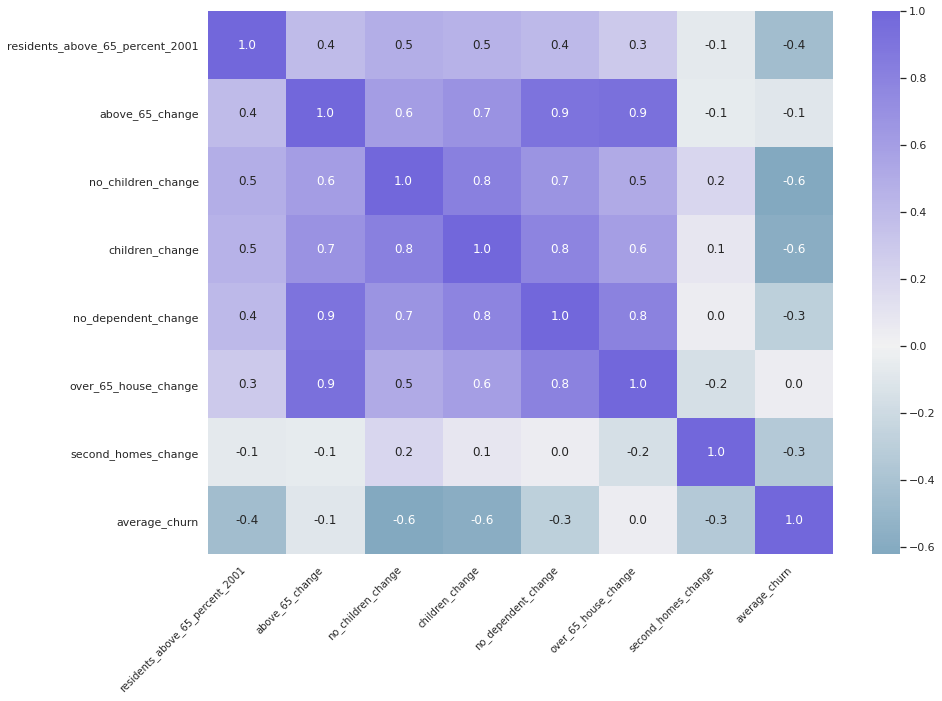

In [95]:
# check for multi-collinearity between variables

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(235.5, 268.1, as_cmap=True)
#cmap = sns.diverging_palette(204,252, as_cmap=True)

ax=sns.heatmap(cluster_1.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")
plt.xticks(rotation=45,ha='right',fontsize=10)
plt.savefig(os.path.join("Figures", 'heat_gent_cluster_raw.png'), transparent=True, dpi=300)


No handles with labels found to put in legend.


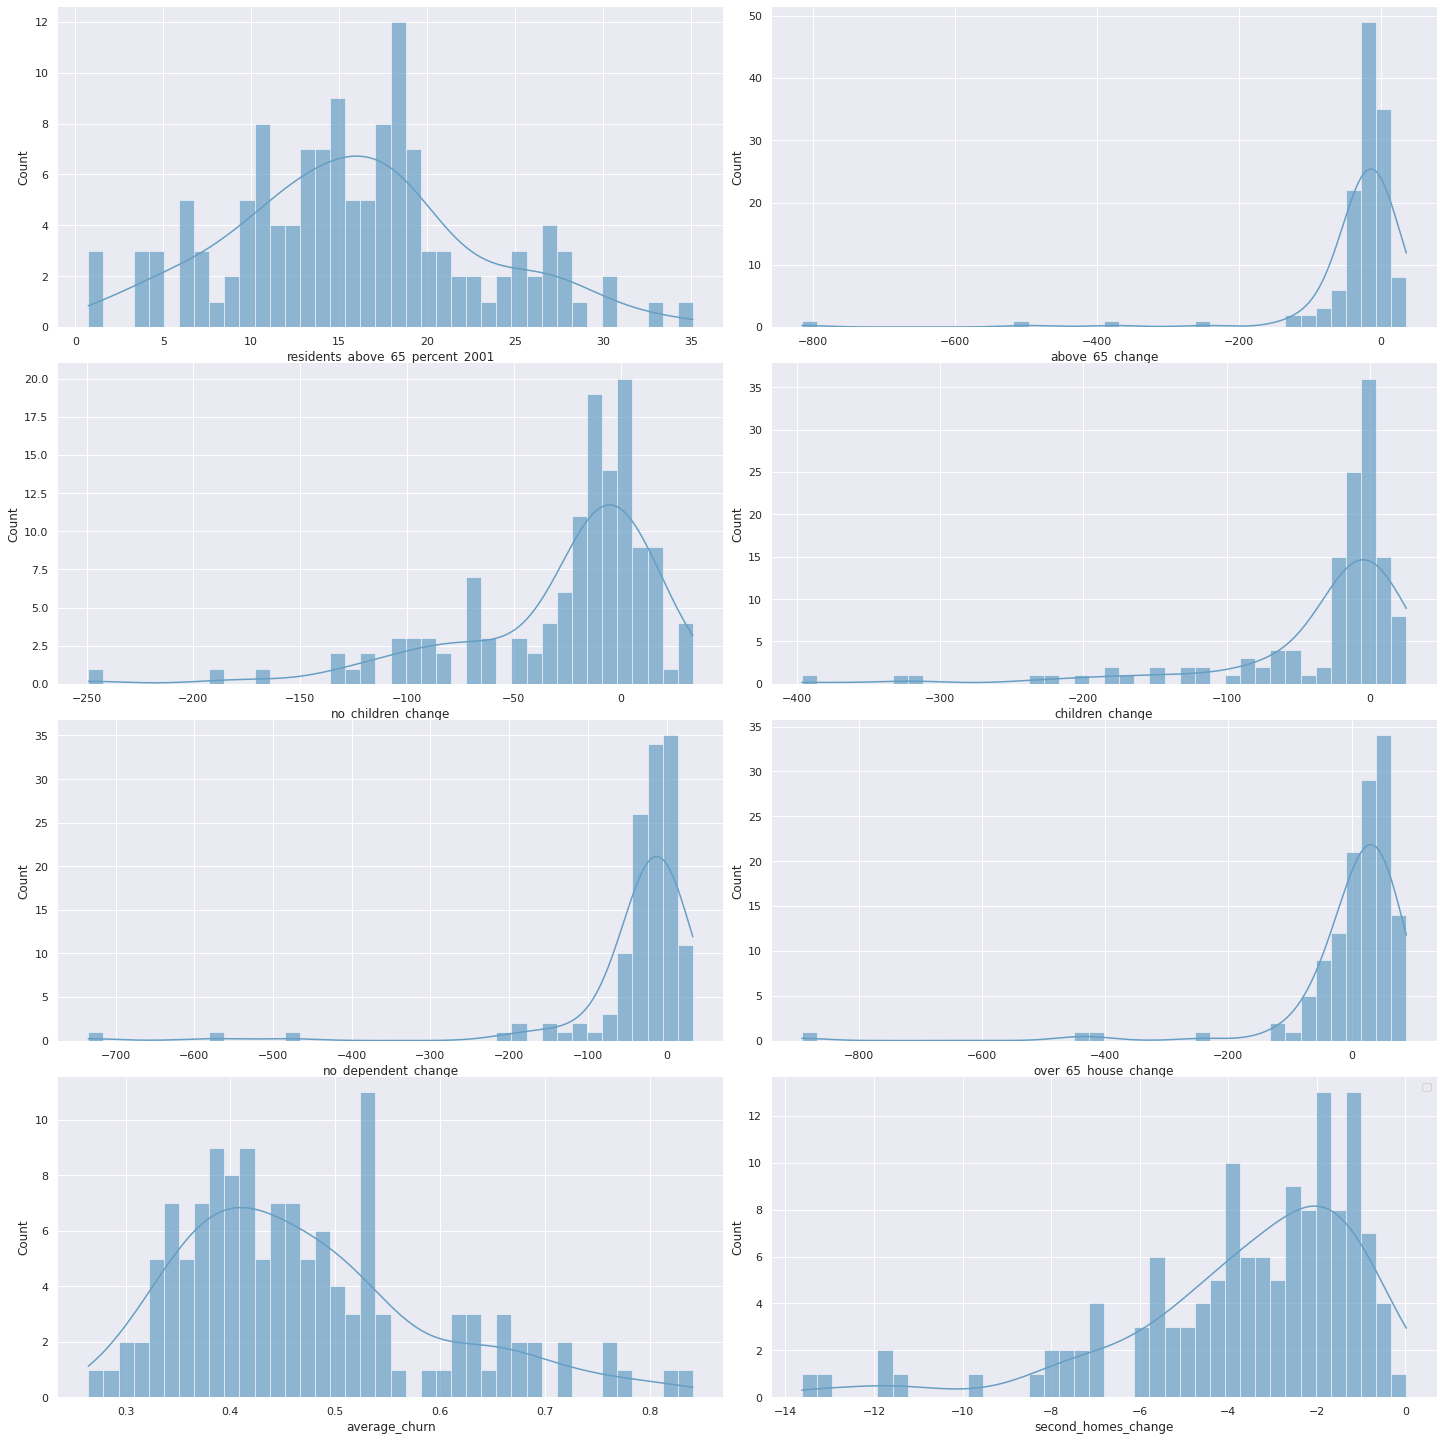

In [96]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
fig.tight_layout()

sns.set(style="whitegrid")
sns.set(font_scale = 1)

sns.histplot(ax=axs[0,0],data=cluster_1, x="residents_above_65_percent_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[0,1],data=cluster_1, x="above_65_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[1,0],data=cluster_1, x="no_children_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[1,1],data=cluster_1, x="children_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[2, 0],data=cluster_1, x="no_dependent_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[2,1],data=cluster_1, x="over_65_house_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[3,0],data=cluster_1, x="average_churn", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[3,1],data=cluster_1, x="second_homes_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

   
plt.legend() 

plt.savefig(os.path.join("Figures", 'hist_gent_cluster_raw.png'), transparent=True, dpi=300)

plt.show()

# 6.2 Transform

In [97]:
# applying cube root transformation to data variables

cluster_1_cubeRoot = np.cbrt(cluster_1)

No handles with labels found to put in legend.


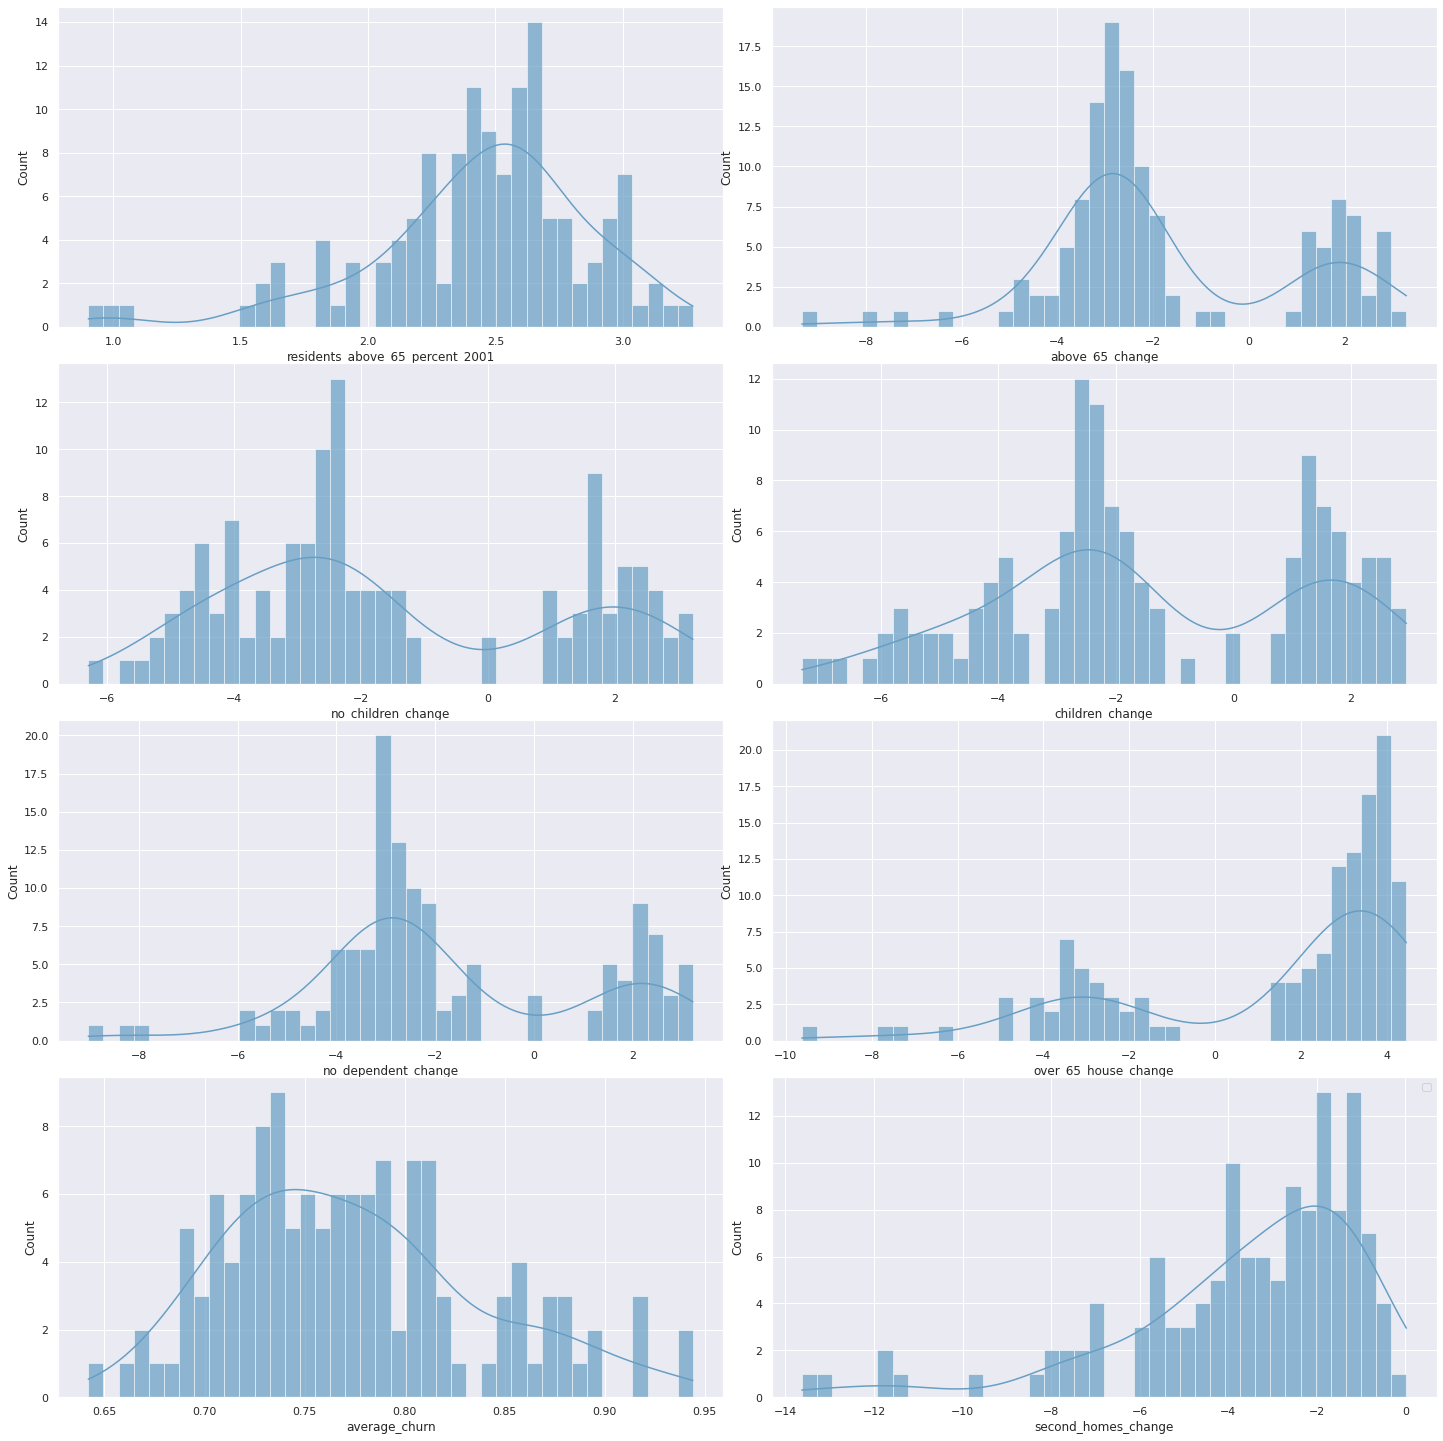

In [98]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
fig.tight_layout()

sns.set(style="whitegrid")
sns.set(font_scale = 1)

sns.histplot(ax=axs[0,0],data=cluster_1_cubeRoot, x="residents_above_65_percent_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[0,1],data=cluster_1_cubeRoot, x="above_65_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[1,0],data=cluster_1_cubeRoot, x="no_children_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[1,1],data=cluster_1_cubeRoot, x="children_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[2, 0],data=cluster_1_cubeRoot, x="no_dependent_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[2,1],data=cluster_1_cubeRoot, x="over_65_house_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[3,0],data=cluster_1_cubeRoot, x="average_churn", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[3,1],data=cluster_1, x="second_homes_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

   
plt.legend() 

plt.savefig(os.path.join("Figures", 'hist_gent_cluster_cube.png'), transparent=True, dpi=300)

plt.show()

In [99]:
# applying the Yeo-Johnson transformation to data variables

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
pt.fit(cluster_1)

cluster_1_yeoJohnson = pt.transform(cluster_1)

In [100]:
cluster_1_yeoJohnson = pd.DataFrame(cluster_1_yeoJohnson, index = cluster_1.index, columns = cluster_1.columns)


In [101]:
cluster_1_yeoJohnson.head()


,residents_above_65_percent_2001,above_65_change,no_children_change,children_change,no_dependent_change,over_65_house_change,second_homes_change,average_churn
LSOA11CD,,,,,,,,
E01023978,1.175181,-0.083941,0.388130,0.048063,-0.216428,-0.919094,0.411127,-0.048479
E01024044,0.141006,0.349993,0.031791,-0.135590,1.653983,1.065421,-0.650901,1.109121
E01024045,1.009976,0.473283,-0.195242,0.424192,0.145537,0.084203,0.105422,-0.188919
E01024046,1.357051,0.643651,-0.535158,-0.055371,-0.135572,0.559222,-0.205152,0.580597
E01024048,-0.680754,2.020734,2.891311,1.154438,-0.451731,1.590953,-0.724172,1.493653


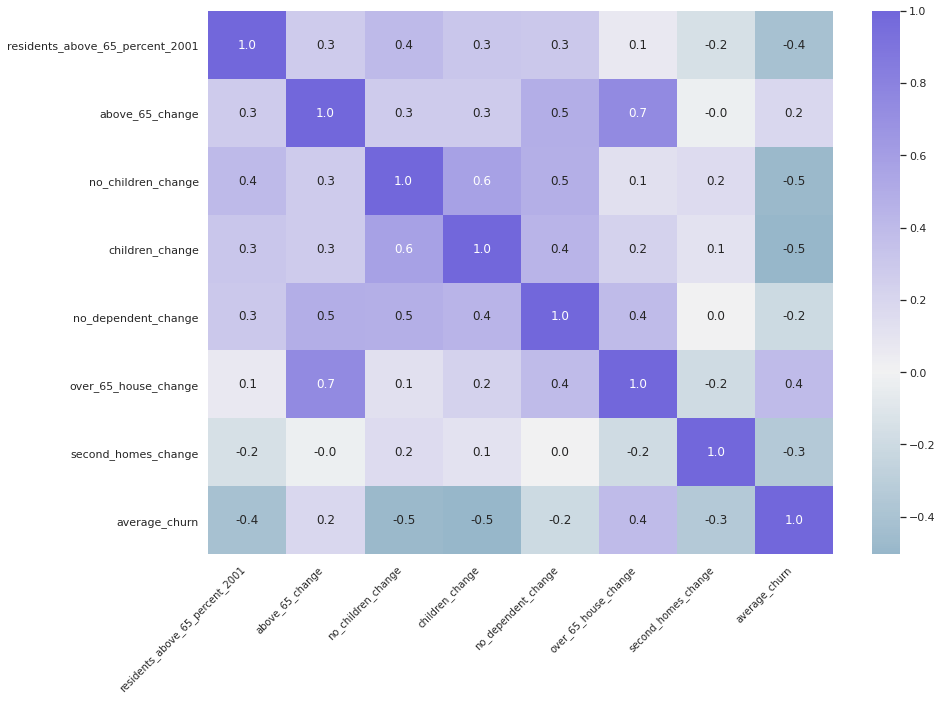

In [102]:
# check for multi-collinearity between variables
# check for multi-collinearity between variables

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(235.5, 268.1, as_cmap=True)
#cmap = sns.diverging_palette(204,252, as_cmap=True)

ax=sns.heatmap(cluster_1_yeoJohnson.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")
plt.xticks(rotation=45,ha='right',fontsize=10)

plt.savefig(os.path.join("Figures", 'heat_gent_cluster_yeo.png'), transparent=True, dpi=300)

In [103]:
# applying the inverse hyperbolic sine transformation to data variables

cluster_1_invSine = np.arcsinh(cluster_1)

No handles with labels found to put in legend.


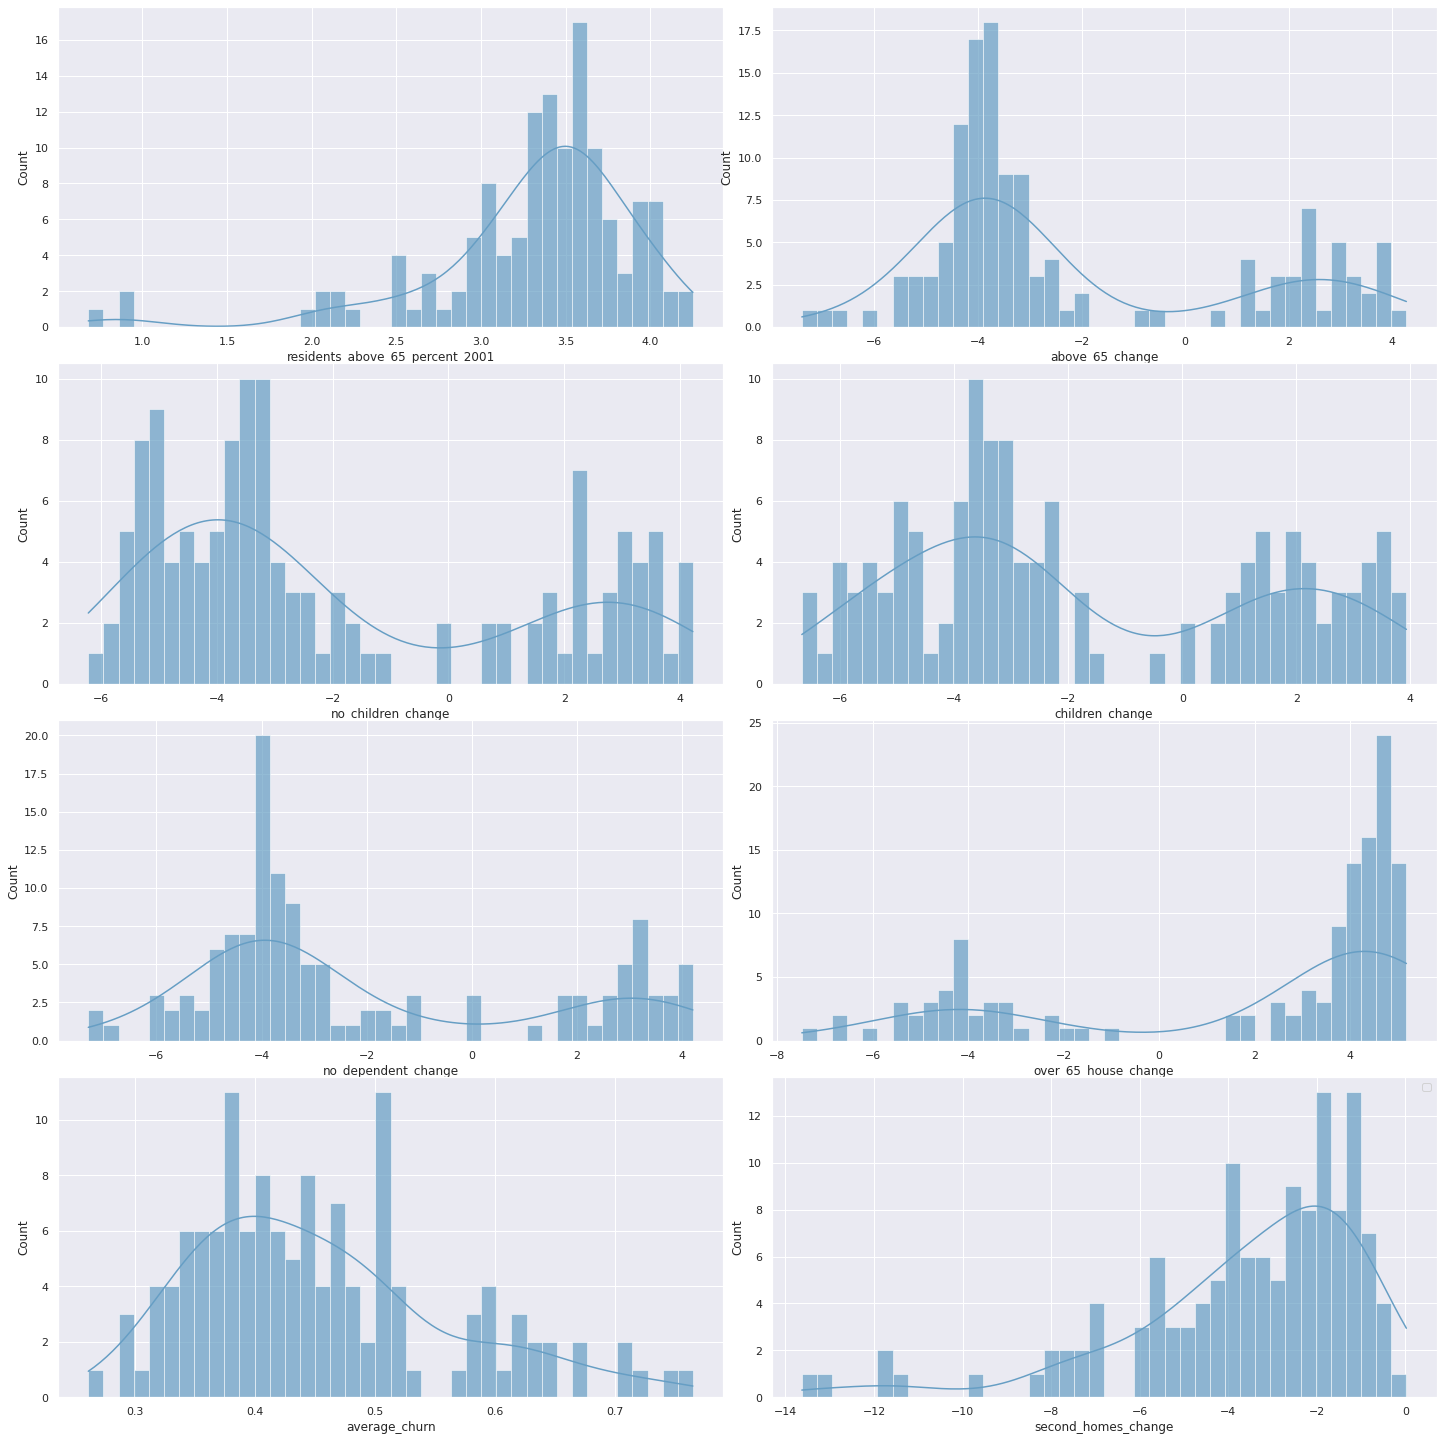

In [104]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,20))
fig.tight_layout()

sns.set(style="whitegrid")
sns.set(font_scale = 1)

sns.histplot(ax=axs[0,0],data=cluster_1_invSine, x="residents_above_65_percent_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[0,1],data=cluster_1_invSine, x="above_65_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[1,0],data=cluster_1_invSine, x="no_children_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[1,1],data=cluster_1_invSine, x="children_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[2, 0],data=cluster_1_invSine, x="no_dependent_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[2,1],data=cluster_1_invSine, x="over_65_house_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

sns.histplot(ax=axs[3,0],data=cluster_1_invSine, x="average_churn", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)
sns.histplot(ax=axs[3,1],data=cluster_1, x="second_homes_change", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=40)

   
plt.legend() 

plt.savefig(os.path.join("Figures", 'hist_gent_cluster_invsine.png'), transparent=True, dpi=300)

plt.show()

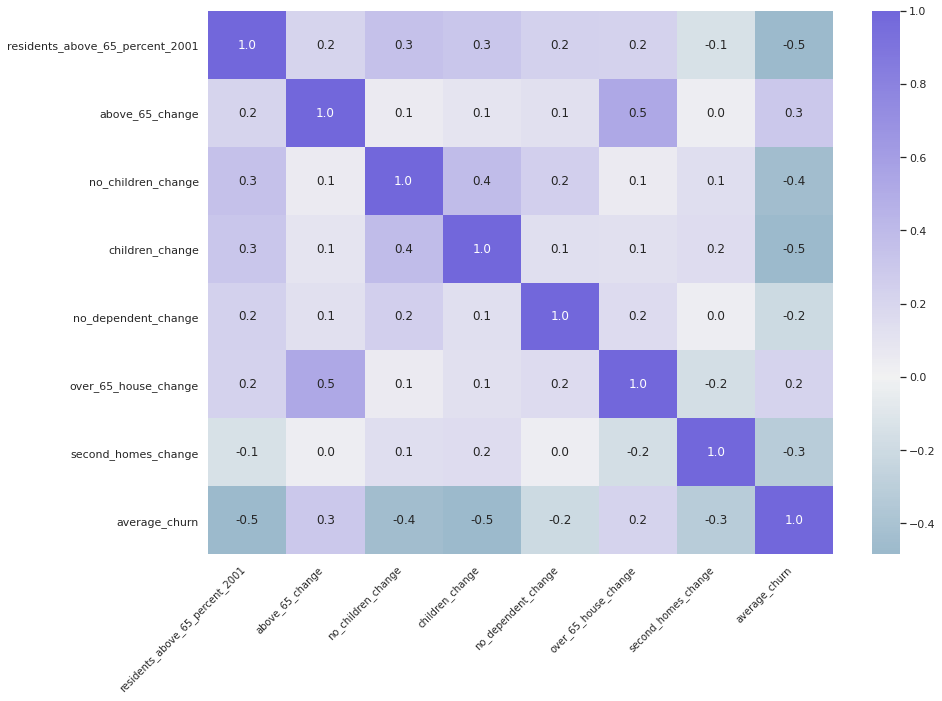

In [105]:
# check for multi-collinearity between variables

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(235.5, 268.1, as_cmap=True)
#cmap = sns.diverging_palette(204,252, as_cmap=True)

ax=sns.heatmap(cluster_1_invSine.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")
plt.xticks(rotation=45,ha='right',fontsize=10)

plt.savefig(os.path.join("Figures", 'heat_gent_cluster_invsine.png'), transparent=True, dpi=300)

# 6.3 Scaling

In [106]:
# applying z-score standardisation on all 4 datasets

from scipy.stats import zscore


cluster_1_noTrans = cluster_1[:]
cluster_1_noTrans_zscore = cluster_1_noTrans.apply(zscore)
cluster_1_cubeRoot_zscore = cluster_1_cubeRoot.apply(zscore)
cluster_1_yeoJohnson_zscore = cluster_1_yeoJohnson.apply(zscore)
cluster_1_invSine_zscore = cluster_1_invSine.apply(zscore)

In [107]:
# applying RobustScaler (inter-quartile range standardisation) on all 4 datasets

from sklearn.preprocessing import RobustScaler

transformer1 = RobustScaler().fit(cluster_1_noTrans)
cluster_1_noTrans_robust = transformer1.transform(cluster_1_noTrans)
cluster_1_noTrans_robust = pd.DataFrame(cluster_1_noTrans_robust, index = cluster_1_noTrans.index, columns = cluster_1_noTrans.columns)


transformer2 = RobustScaler().fit(cluster_1_cubeRoot)
cluster_1_cubeRoot_robust = transformer2.transform(cluster_1_cubeRoot)
cluster_1_cubeRoot_robust = pd.DataFrame(cluster_1_cubeRoot_robust, index = cluster_1_cubeRoot.index, columns = cluster_1_cubeRoot.columns)


transformer3 = RobustScaler().fit(cluster_1_yeoJohnson)
cluster_1_yeoJohnson_robust = transformer3.transform(cluster_1_yeoJohnson)
cluster_1_yeoJohnson_robust = pd.DataFrame(cluster_1_yeoJohnson_robust, index = cluster_1_yeoJohnson.index, columns = cluster_1_yeoJohnson.columns)


transformer4 = RobustScaler().fit(cluster_1_invSine)
cluster_1_invSine_robust = transformer4.transform(cluster_1_invSine)
cluster_1_invSine_robust = pd.DataFrame(cluster_1_invSine_robust, index = cluster_1_invSine.index, columns = cluster_1_invSine.columns)

In [108]:
# applying RobustScaler (inter-decile range standardisation) on all 4 datasets

transformer5 = RobustScaler(quantile_range=(10.0, 90.0)).fit(cluster_1_noTrans)
cluster_1_noTrans_decile = transformer5.transform(cluster_1_noTrans)
cluster_1_noTrans_decile = pd.DataFrame(cluster_1_noTrans_decile, index = cluster_1_noTrans.index, columns = cluster_1_noTrans.columns)


transformer6 = RobustScaler(quantile_range=(10.0, 90.0)).fit(cluster_1_cubeRoot)
cluster_1_cubeRoot_decile = transformer6.transform(cluster_1_cubeRoot)
cluster_1_cubeRoot_decile = pd.DataFrame(cluster_1_cubeRoot_decile, index = cluster_1_cubeRoot.index, columns = cluster_1_cubeRoot.columns)


transformer7 = RobustScaler(quantile_range=(10.0, 90.0)).fit(cluster_1_yeoJohnson)
cluster_1_yeoJohnson_decile = transformer7.transform(cluster_1_yeoJohnson)
cluster_1_yeoJohnson_decile = pd.DataFrame(cluster_1_yeoJohnson_decile, index = cluster_1_yeoJohnson.index, columns = cluster_1_yeoJohnson.columns)


transformer8 = RobustScaler(quantile_range=(10.0, 90.0)).fit(cluster_1_invSine)
cluster_1_invSine_decile = transformer8.transform(cluster_1_invSine)
cluster_1_invSine_decile = pd.DataFrame(cluster_1_invSine_decile, index = cluster_1_invSine.index, columns = cluster_1_invSine.columns)

In [109]:
#check for heavily-skewed variables (i.e. skewness scores beyond +/- 1)

df_full = [cluster_1_noTrans_zscore, cluster_1_cubeRoot_zscore, cluster_1_yeoJohnson_zscore, cluster_1_invSine_zscore, cluster_1_noTrans_robust, cluster_1_cubeRoot_robust, cluster_1_yeoJohnson_robust, cluster_1_invSine_robust, cluster_1_noTrans_decile, cluster_1_cubeRoot_decile, cluster_1_yeoJohnson_decile, cluster_1_invSine_decile]
df_full_name = ["cluster_1_noTrans_zscore", "cluster_1_cubeRoot_zscore", "cluster_1_yeoJohnson_zscore", "cluster_1_invSine_zscore", "cluster_1_noTrans_robust", "cluster_1_cubeRoot_robust", "cluster_1_yeoJohnson_robust", "cluster_1_invSine_robust", "cluster_1_noTrans_decile", "cluster_1_cubeRoot_decile", "cluster_1_yeoJohnson_decile", "cluster_1_invSine_decile"]

for method in range(len(df_full)):
    counter = 0
    for col in range(0,8):
        if df_full[method][df_full[method].columns[col]].skew() > 1:
            counter += 1
        elif df_full[method][df_full[method].columns[col]].skew() <- 1:
            counter += 1
    print(str(df_full_name[method]) + " has " + str(counter) + " variables with skew >1 or <-1 \n")

cluster_1_noTrans_zscore has 6 variables with skew >1 or <-1 

cluster_1_cubeRoot_zscore has 2 variables with skew >1 or <-1 

cluster_1_yeoJohnson_zscore has 0 variables with skew >1 or <-1 

cluster_1_invSine_zscore has 1 variables with skew >1 or <-1 

cluster_1_noTrans_robust has 6 variables with skew >1 or <-1 

cluster_1_cubeRoot_robust has 2 variables with skew >1 or <-1 

cluster_1_yeoJohnson_robust has 0 variables with skew >1 or <-1 

cluster_1_invSine_robust has 1 variables with skew >1 or <-1 

cluster_1_noTrans_decile has 6 variables with skew >1 or <-1 

cluster_1_cubeRoot_decile has 2 variables with skew >1 or <-1 

cluster_1_yeoJohnson_decile has 0 variables with skew >1 or <-1 

cluster_1_invSine_decile has 1 variables with skew >1 or <-1 



For n_clusters = 2 The average silhouette_score is : 0.8623958693617424
For n_clusters = 3 The average silhouette_score is : 0.5682797869981822
For n_clusters = 4 The average silhouette_score is : 0.5485946082531274
For n_clusters = 5 The average silhouette_score is : 0.5478538840819727
For n_clusters = 6 The average silhouette_score is : 0.2623901436575728
For n_clusters = 7 The average silhouette_score is : 0.2849588324505972
For n_clusters = 8 The average silhouette_score is : 0.27223007232101415
For n_clusters = 9 The average silhouette_score is : 0.27248323181357964
For n_clusters = 10 The average silhouette_score is : 0.2730306724600425


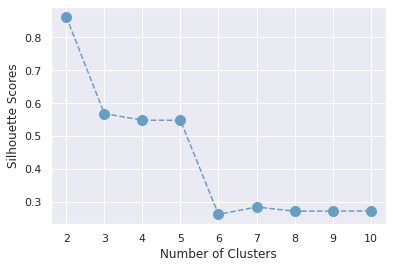

In [110]:
# check and plot silhouette scores to determine the optimal number of clusters

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
Sum_of_squared_distances = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(cluster_1)
    Sum_of_squared_distances.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(cluster_1, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

clusters = pd.DataFrame(silhouette_scores, index=None).reset_index().rename(columns={"index":"Cluster",0:"silhouette_score"})

plt.plot(range_n_clusters, silhouette_scores, 'o--', color="#669EC4", ms=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.savefig(os.path.join("Figures", 'line_cluster_sil.png'), transparent=True, dpi=300)
plt.show()

# 6.4 Cluster

In [111]:
permutation = ["yeoJohnson-zscore", "yeoJohnson-robust(interquartile)","yeoJohnson-robust(interdecile)", "cubeRoot-zscore", "cubeRoot-robust(interquartile)","cubeRoot-robust(interdecile)","invSine-zscore", "invSine-robust(interquartile)", "invSine-robust(interdecile)"]
calinski_harabasz_scores = []

In [112]:
n_clusters = 3

In [113]:
# k-means clustering for yeo-johnson dataset permutations

cluster_1_yeoJohnson_zscore_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_yeoJohnson_zscore)
cluster_1_yeoJohnson_robust_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_yeoJohnson_robust)
cluster_1_yeoJohnson_decile_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_yeoJohnson_decile)

cluster_1_yeoJohnson_zscore_labels = cluster_1_yeoJohnson_zscore_kmeans.labels_
cluster_1_yeoJohnson_robust_labels = cluster_1_yeoJohnson_robust_kmeans.labels_
cluster_1_yeoJohnson_decile_labels = cluster_1_yeoJohnson_decile_kmeans.labels_

In [114]:
cluster_1_yJ_zscore_original = cluster_1[:]
cluster_1_yJ_zscore_original["cluster_1_yeoJohnson_zscore_labels"]=cluster_1_yeoJohnson_zscore_labels

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [115]:
cluster_1_yJ_robust_original = cluster_1[:]
cluster_1_yJ_robust_original["cluster_1_yeoJohnson_robust_labels"]=cluster_1_yeoJohnson_robust_labels

In [116]:
cluster_1_yJ_decile_original = cluster_1[:]
cluster_1_yJ_decile_original["cluster_1_yeoJohnson_decile_labels"]=cluster_1_yeoJohnson_decile_labels

In [117]:
# measuring the performance for yeo-johnson dataset permutations

from sklearn import metrics
from sklearn.metrics import pairwise_distances

print(metrics.calinski_harabasz_score(cluster_1_yJ_zscore_original, cluster_1_yeoJohnson_zscore_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_yJ_zscore_original, cluster_1_yeoJohnson_zscore_labels))

print(metrics.calinski_harabasz_score(cluster_1_yJ_robust_original, cluster_1_yeoJohnson_robust_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_yJ_robust_original, cluster_1_yeoJohnson_robust_labels))

print(metrics.calinski_harabasz_score(cluster_1_yJ_decile_original, cluster_1_yeoJohnson_decile_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_yJ_decile_original, cluster_1_yeoJohnson_decile_labels))

38.87864670871005
180.90017914292957
40.222054963931285


In [118]:
# k-means clustering for cube-root dataset permutations

cluster_1_cubeRoot_zscore_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_cubeRoot_zscore)
cluster_1_cubeRoot_robust_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_cubeRoot_robust)
cluster_1_cubeRoot_decile_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_cubeRoot_decile)

cluster_1_cubeRoot_zscore_labels = cluster_1_cubeRoot_zscore_kmeans.labels_
cluster_1_cubeRoot_robust_labels = cluster_1_cubeRoot_robust_kmeans.labels_
cluster_1_cubeRoot_decile_labels = cluster_1_cubeRoot_decile_kmeans.labels_

In [119]:
cluster_1_cB_zscore_original = cluster_1[:]
cluster_1_cB_zscore_original["cluster_1_cubeRoot_zscore_labels"]=cluster_1_cubeRoot_zscore_labels

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [120]:
cluster_1_cB_robust_original = cluster_1[:]
cluster_1_cB_robust_original["cluster_1_cubeRoot_robust_labels"]=cluster_1_cubeRoot_robust_labels

In [121]:
cluster_1_cB_decile_original = cluster_1[:]
cluster_1_cB_decile_original["cluster_1_cubeRoot_decile_labels"]=cluster_1_cubeRoot_decile_labels


In [122]:
# measuring the performance for cube-root dataset permutations

print(metrics.calinski_harabasz_score(cluster_1_cB_zscore_original, cluster_1_cubeRoot_zscore_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_cB_zscore_original, cluster_1_cubeRoot_zscore_labels))

print(metrics.calinski_harabasz_score(cluster_1_cB_robust_original, cluster_1_cubeRoot_robust_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_cB_robust_original, cluster_1_cubeRoot_robust_labels))

print(metrics.calinski_harabasz_score(cluster_1_cB_decile_original, cluster_1_cubeRoot_decile_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_cB_decile_original, cluster_1_cubeRoot_decile_labels))

32.05779773455573
47.01553861341967
31.999144322353455


In [123]:
# k-means clustering for inverse sine dataset permutations

cluster_1_invSine_zscore_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_invSine_zscore)
cluster_1_invSine_robust_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_invSine_robust)
cluster_1_invSine_decile_kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", random_state=0, n_init=5000, max_iter=50000).fit(cluster_1_invSine_decile)

cluster_1_invSine_zscore_labels = cluster_1_invSine_zscore_kmeans.labels_
cluster_1_invSine_robust_labels = cluster_1_invSine_robust_kmeans.labels_
cluster_1_invSine_decile_labels = cluster_1_invSine_decile_kmeans.labels_

In [124]:
cluster_1_iS_zscore_original = cluster_1[:]
cluster_1_iS_zscore_original["cluster_1_invSine_zscore_labels"]=cluster_1_invSine_zscore_labels

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [125]:
cluster_1_iS_robust_original = cluster_1[:]
cluster_1_iS_robust_original["cluster_1_invSine_robust_labels"]=cluster_1_invSine_robust_labels

In [126]:
cluster_1_iS_decile_original = cluster_1[:]
cluster_1_iS_decile_original["cluster_1_invSine_decile_labels"]=cluster_1_invSine_decile_labels

In [127]:
# measuring the performance for inverse sine dataset permutations

print(metrics.calinski_harabasz_score(cluster_1_iS_zscore_original, cluster_1_invSine_zscore_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_iS_zscore_original, cluster_1_invSine_zscore_labels))

print(metrics.calinski_harabasz_score(cluster_1_iS_robust_original, cluster_1_invSine_robust_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_iS_robust_original, cluster_1_invSine_robust_labels))

print(metrics.calinski_harabasz_score(cluster_1_iS_decile_original, cluster_1_invSine_decile_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_1_iS_decile_original, cluster_1_invSine_decile_labels))

25.96842442597108
40.175190016453115
29.50883500724097


/tmp/ipykernel_234/2680061848.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(permutation, fontsize=14)
/tmp/ipykernel_234/2680061848.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(0,140,20), fontsize=14)


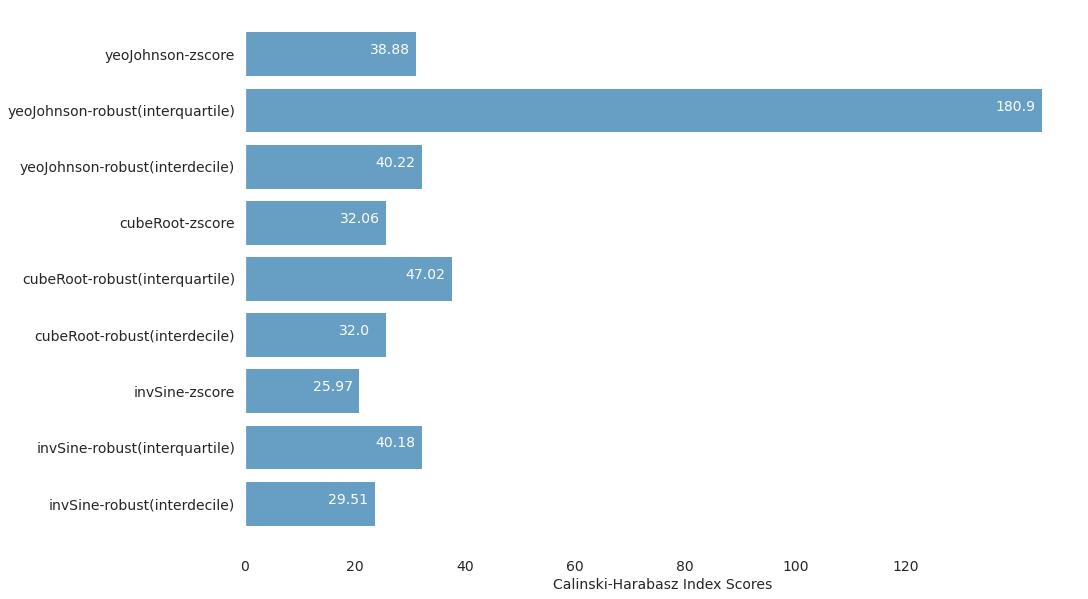

In [128]:
plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(figsize=(15, 10))

bar = plt.barh(permutation, calinski_harabasz_scores, color = ["#669EC4"])

for i in range(len(permutation)):
    plt.text(x = calinski_harabasz_scores[i]-10.5, y = i, s = calinski_harabasz_scores[i].round(2), size = 14, color="white")
    
ax.set_yticklabels(permutation, fontsize=14)
ax.set_xticklabels(range(0,140,20), fontsize=14)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Calinski-Harabasz Index Scores',fontsize=14)

plt.savefig(os.path.join("Figures", 'bar_gent_cluster_perf.png'), transparent=True, dpi=300)

plt.show()

In [129]:
# extracting cluster details of the best-performing dataset

cluster_1_yJ_decile_original.groupby("cluster_1_yeoJohnson_decile_labels").size()

cluster_1_yeoJohnson_decile_labels
0    75
1    16
2    40
dtype: int64

In [130]:
# appending cluster labels to main dataset

cluster_1_yeoJohnson_decile["cluster_1_yeoJohnson_decile_labels"]=cluster_1_yeoJohnson_decile_labels

# 7. Plot

In [131]:
# creating a new dataset for plotting purposes

radar_1 = cluster_1_yeoJohnson_decile.groupby("cluster_1_yeoJohnson_decile_labels").mean().reset_index()

In [132]:
# check the means of the entire dataset

cluster_1_yeoJohnson_decile.mean()

residents_above_65_percent_2001       0.003349
above_65_change                       0.065275
no_children_change                   -0.014554
children_change                      -0.007518
no_dependent_change                   0.051778
over_65_house_change                  0.017476
second_homes_change                   0.001530
average_churn                         0.004888
cluster_1_yeoJohnson_decile_labels    0.732824
dtype: float64

In [133]:
# appending dataset average values to main dataset

radar_avg = cluster_1_yeoJohnson_decile.drop(columns = ["cluster_1_yeoJohnson_decile_labels"]).mean().reset_index()

In [134]:
# rename columns for legibility

radar_avg = radar_avg.rename(columns={"index":"var", 0: "value"})

In [156]:
radar_1.to_csv("save.csv")

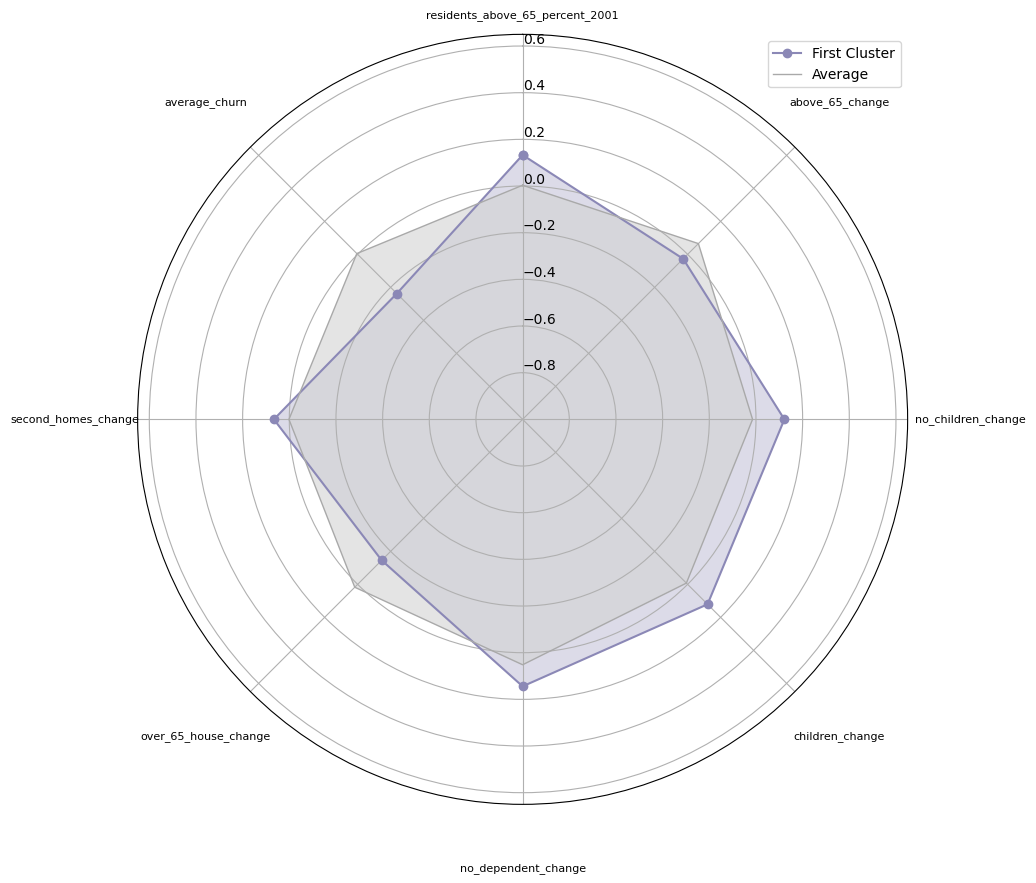

In [136]:
# Reference for code: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
# plot the 1st cluster
plt.style.use('default')

from math import pi

fig1, ax = plt.subplots()
fig1.set_size_inches(14, 10)

# number of variable
categories=list(radar_1)[1:]
N = len(categories)
 
# plotting for the 1st variable
values=radar_1.iloc[0,1:].values.flatten().tolist()
values += values[:1]
values

# ------- PART 1: Create background
 
# number of variables
categories=list(radar_1)[1:]
N = len(categories)
 
# angles for plotting
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
ax.set_rlabel_position(0)
plt.rcParams['xtick.major.pad']='35'
plt.xticks(angles[:-1], categories, size = 8, rotation=90)
 
# Draw ylabels
plt.ylim(-1,0.65)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=radar_1.iloc[0,1:].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, color = "#8B88B6", linestyle='solid', marker="o", label="First Cluster")
ax.fill(angles, values, '#8B88B6', alpha=0.3)
 
# Ind2
values=radar_avg.iloc[:,1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, color="darkgrey", linestyle='solid', label="Average")
ax.fill(angles, values, 'lightgrey', alpha=0.6)
 
plt.savefig(os.path.join("Figures", 'spider_gent_cluster1.png'), transparent=True, dpi=300)

# Add legend
plt.legend(loc='upper right')

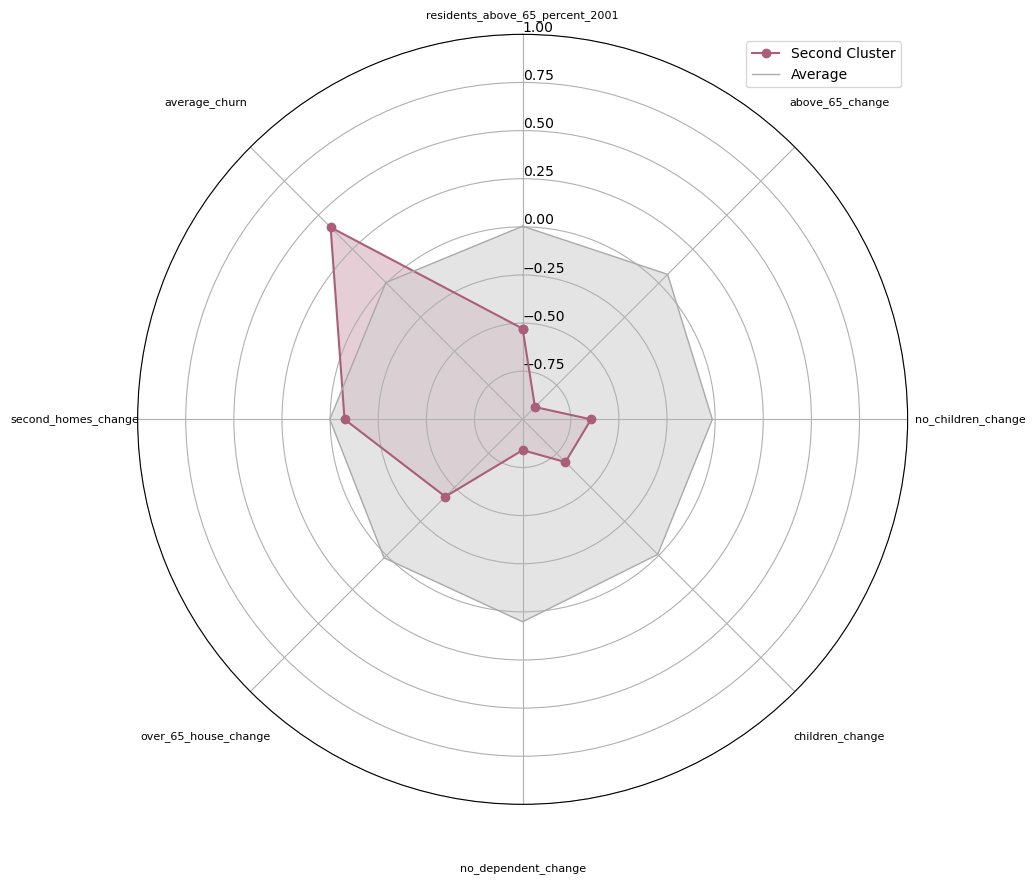

In [137]:
# Reference for code: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
# plot the 1st cluster
plt.style.use('default')

from math import pi

fig1, ax = plt.subplots()
fig1.set_size_inches(14, 10)

# number of variable
categories=list(radar_1)[1:]
N = len(categories)
 
# plotting for the 1st variable
values=radar_1.iloc[0,1:].values.flatten().tolist()
values += values[:1]
values

# ------- PART 1: Create background
 
# number of variables
categories=list(radar_1)[1:]
N = len(categories)
 
# angles for plotting
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
ax.set_rlabel_position(0)
plt.rcParams['xtick.major.pad']='35'
plt.xticks(angles[:-1], categories, size = 8, rotation=90)
 
# Draw ylabels
plt.ylim(-1,1)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=radar_1.iloc[1,1:].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, color = "#AA5E79", linestyle='solid', marker="o", label="Second Cluster")
ax.fill(angles, values, '#AA5E79', alpha=0.3)
 
# Ind2
values=radar_avg.iloc[:,1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, color="darkgrey", linestyle='solid', label="Average")
ax.fill(angles, values, 'lightgrey', alpha=0.6)
 
# Add legend

plt.savefig(os.path.join("Figures", 'spider_gent_cluster2.png'), transparent=True, dpi=300)

plt.legend(loc='upper right')

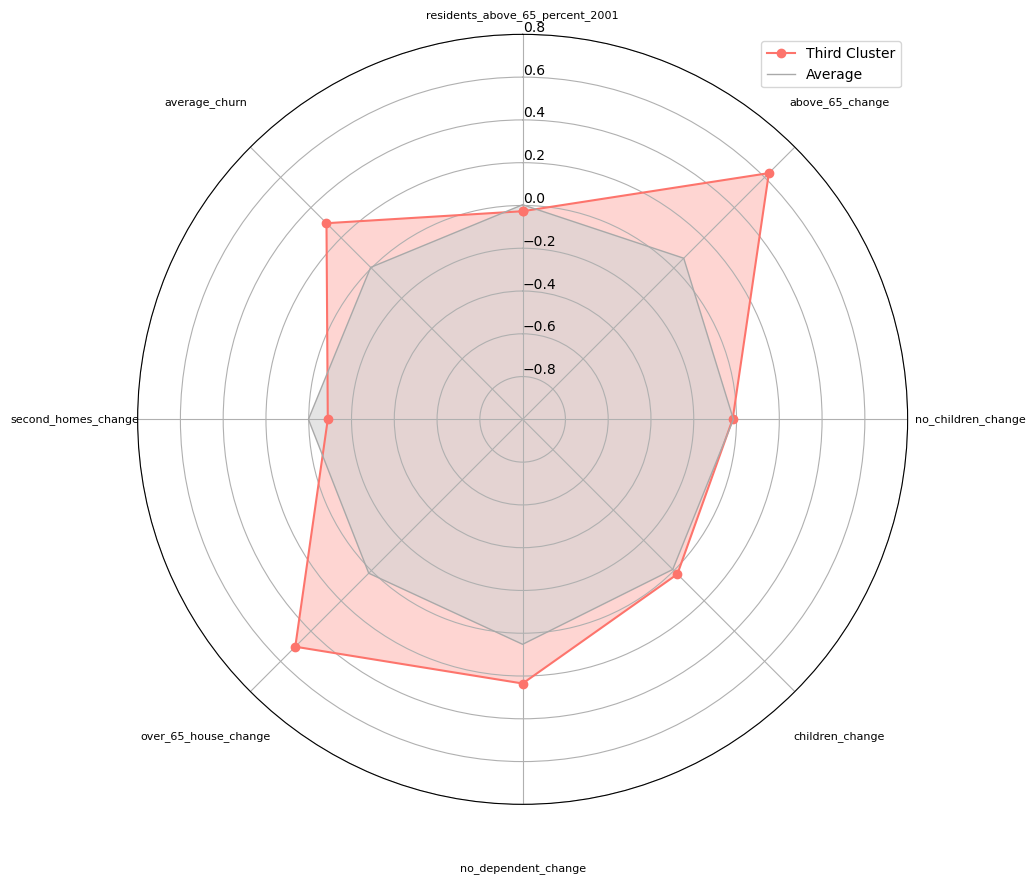

In [138]:
# Reference for code: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
# plot the 1st cluster
plt.style.use('default')

from math import pi

fig1, ax = plt.subplots()
fig1.set_size_inches(14, 10)

# number of variable
categories=list(radar_1)[1:]
N = len(categories)
 
# plotting for the 1st variable
values=radar_1.iloc[0,1:].values.flatten().tolist()
values += values[:1]
values

# ------- PART 1: Create background
 
# number of variables
categories=list(radar_1)[1:]
N = len(categories)
 
# angles for plotting
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
ax.set_rlabel_position(0)
plt.rcParams['xtick.major.pad']='35'
plt.xticks(angles[:-1], categories, size = 8, rotation=90)
 
# Draw ylabels
plt.ylim(-1,0.8)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=radar_1.iloc[2,1:].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, color = "#fd746c", linestyle='solid', marker="o", label="Third Cluster")
ax.fill(angles, values, '#fd746c', alpha=0.3)
 
# Ind2
values=radar_avg.iloc[:,1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, color="darkgrey", linestyle='solid', label="Average")
ax.fill(angles, values, 'lightgrey', alpha=0.6)

plt.savefig(os.path.join("Figures", 'spider_gent_cluster3.png'), transparent=True, dpi=300)

 
# Add legend
plt.legend(loc='upper right')

In [139]:
# create new feature column in main dataset to host label categories

cluster_1_yJ_decile_cat = cluster_1_yJ_decile_original[:].reset_index()
cluster_1_yJ_decile_cat["cluster_1_yJ_decile_cat"] = ""

In [140]:
cluster_1_yJ_decile_cat.head()


,LSOA11CD,residents_above_65_percent_2001,above_65_change,no_children_change,children_change,no_dependent_change,over_65_house_change,second_homes_change,average_churn,cluster_1_yeoJohnson_decile_labels,cluster_1_yJ_decile_cat
0,E01023978,24.139999,-16.554054,0.000000,-7.377049,-25.641026,-30.000000,-2.127273,0.4455,0,
1,E01024044,16.530001,1.503759,-13.385827,-17.037037,20.000000,59.836066,-4.543833,0.5950,2,
2,E01024045,22.889999,3.519062,-24.468085,2.597403,-2.941176,30.630631,-2.672059,0.4316,0,
3,E01024046,25.530001,5.896806,-43.298969,-12.500000,-19.565217,45.323741,-3.337575,0.5175,2,
4,E01024048,10.900000,20.370370,33.802817,10.294118,-45.833333,74.074074,-4.776277,0.6664,2,


In [141]:
radar_1

,cluster_1_yeoJohnson_decile_labels,residents_above_65_percent_2001,above_65_change,no_children_change,children_change,no_dependent_change,over_65_house_change,second_homes_change,average_churn
0,0,0.133005,-0.026985,0.121777,0.120810,0.144289,-0.145699,0.066129,-0.237459
1,1,-0.528798,-0.909408,-0.644686,-0.685930,-0.840004,-0.432154,-0.074822,0.410857
2,2,-0.026897,0.628135,-0.018123,0.023233,0.235033,0.503280,-0.089054,0.296901


In [142]:
# parse cluster labels to derive their categories 

cluster_1_yJ_decile_cat["cluster_1_yJ_decile_cat"] = "cluster3"

for i in range(len(cluster_1_yJ_decile_cat)):
    if cluster_1_yJ_decile_cat.loc[i, "cluster_1_yeoJohnson_decile_labels"]==0:
        cluster_1_yJ_decile_cat.loc[i, "cluster_1_yJ_decile_cat"]="cluster1"
    if cluster_1_yJ_decile_cat.loc[i, "cluster_1_yeoJohnson_decile_labels"]==1:
        cluster_1_yJ_decile_cat.loc[i, "cluster_1_yJ_decile_cat"]="cluster2"


In [143]:
cluster_1_yJ_decile_cat['cluster_1_yJ_decile_cat']. value_counts() 

cluster1    75
cluster3    40
cluster2    16
Name: cluster_1_yJ_decile_cat, dtype: int64

In [144]:
lsoa_2011 = gpd.read_file(os.path.join(shapefiles, "LSOA_KENT_2011.shp"))
outline = gpd.read_file(os.path.join(shapefiles, "KENT_OUTLINE.shp"))

In [145]:
cluster_1_yJ_decile_cat_gdf = pd.merge(lsoa_2011, cluster_1_yJ_decile_cat, on="LSOA11CD", how="right")

/tmp/ipykernel_234/3642981792.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(index, size=20)


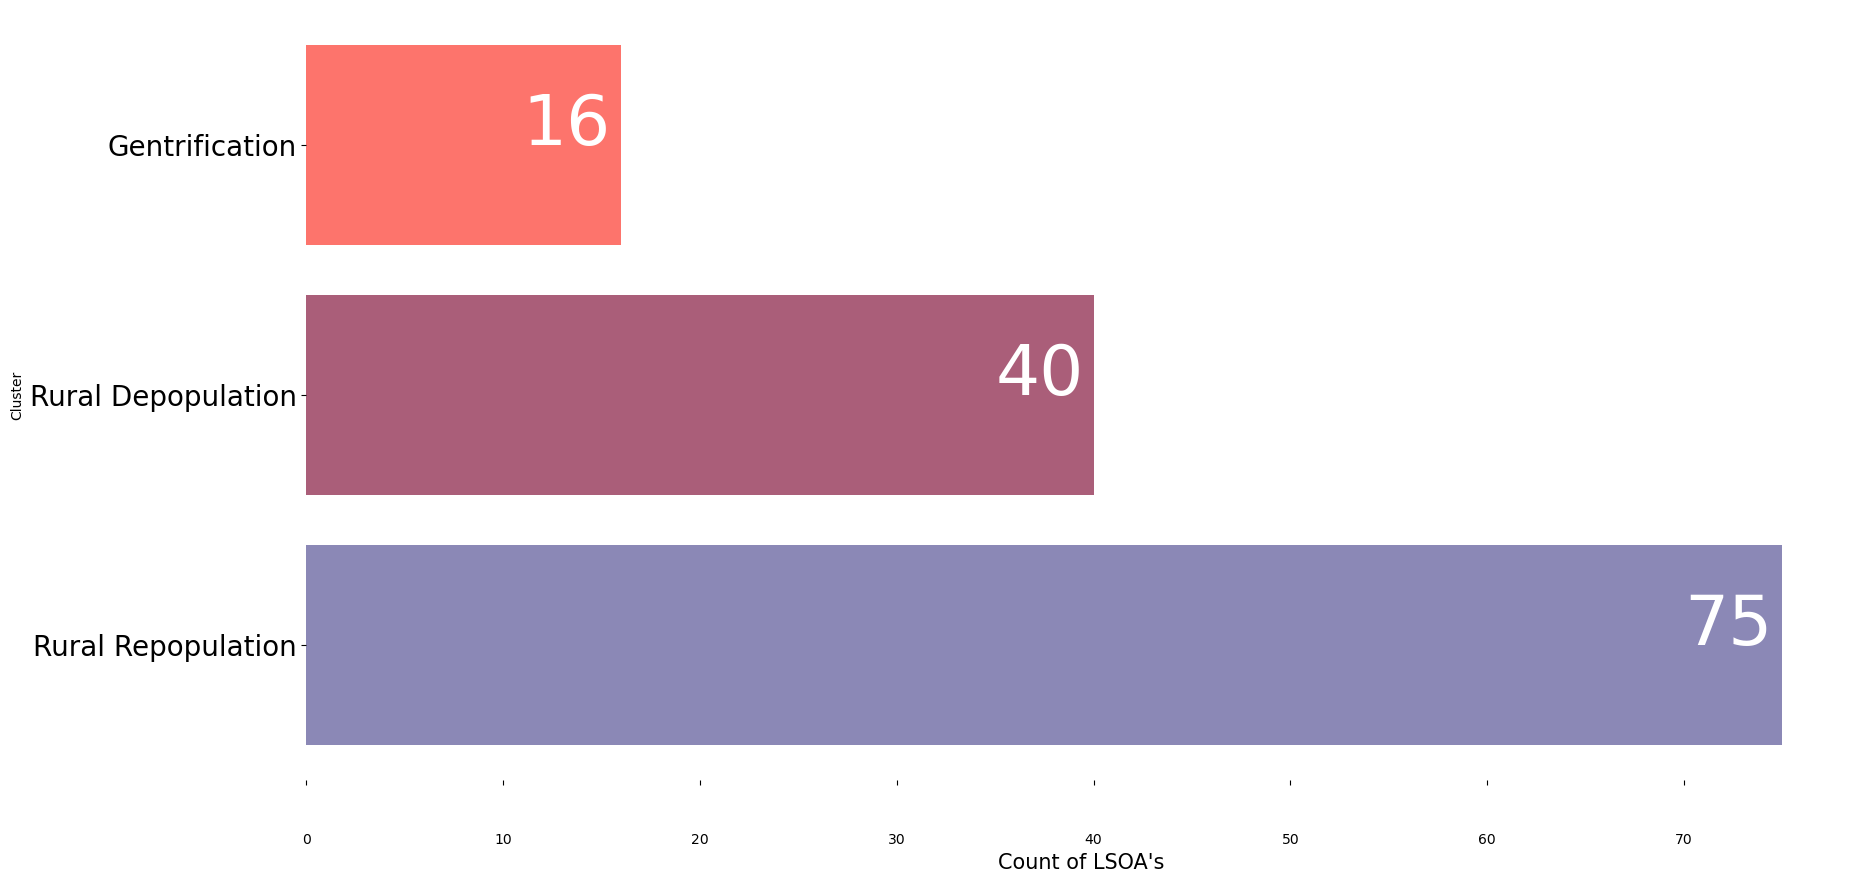

In [188]:
# Plot bar graph of counts

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

# check dataframe

count = pd.DataFrame(cluster_1_yJ_decile_cat_gdf.groupby(cluster_1_yJ_decile_cat_gdf["cluster_1_yJ_decile_cat"]).size()).reset_index()
count = count.rename(columns={0:"count"}).sort_values(by="count", ascending=False)
count

fig, ax = plt.subplots(figsize=(20, 10))

index = ["Rural Repopulation","Rural Depopulation", "Gentrification" ]
bar = plt.barh(count['cluster_1_yJ_decile_cat'], count['count'], color = ["#8B88B6", "#AA5E79" , "#fd746c"])

for i, v in enumerate(count["count"]):
    ax.text(v - 5, i , str(v), color='white', size=50)
    
plt.xlabel("Count of LSOA's", size=15)
plt.ylabel('Cluster')
ax.set_yticklabels(index, size=20)
plt.savefig(os.path.join("Figures", 'bar_gent_cats_count.png'), transparent=True, dpi=300)

plt.show()

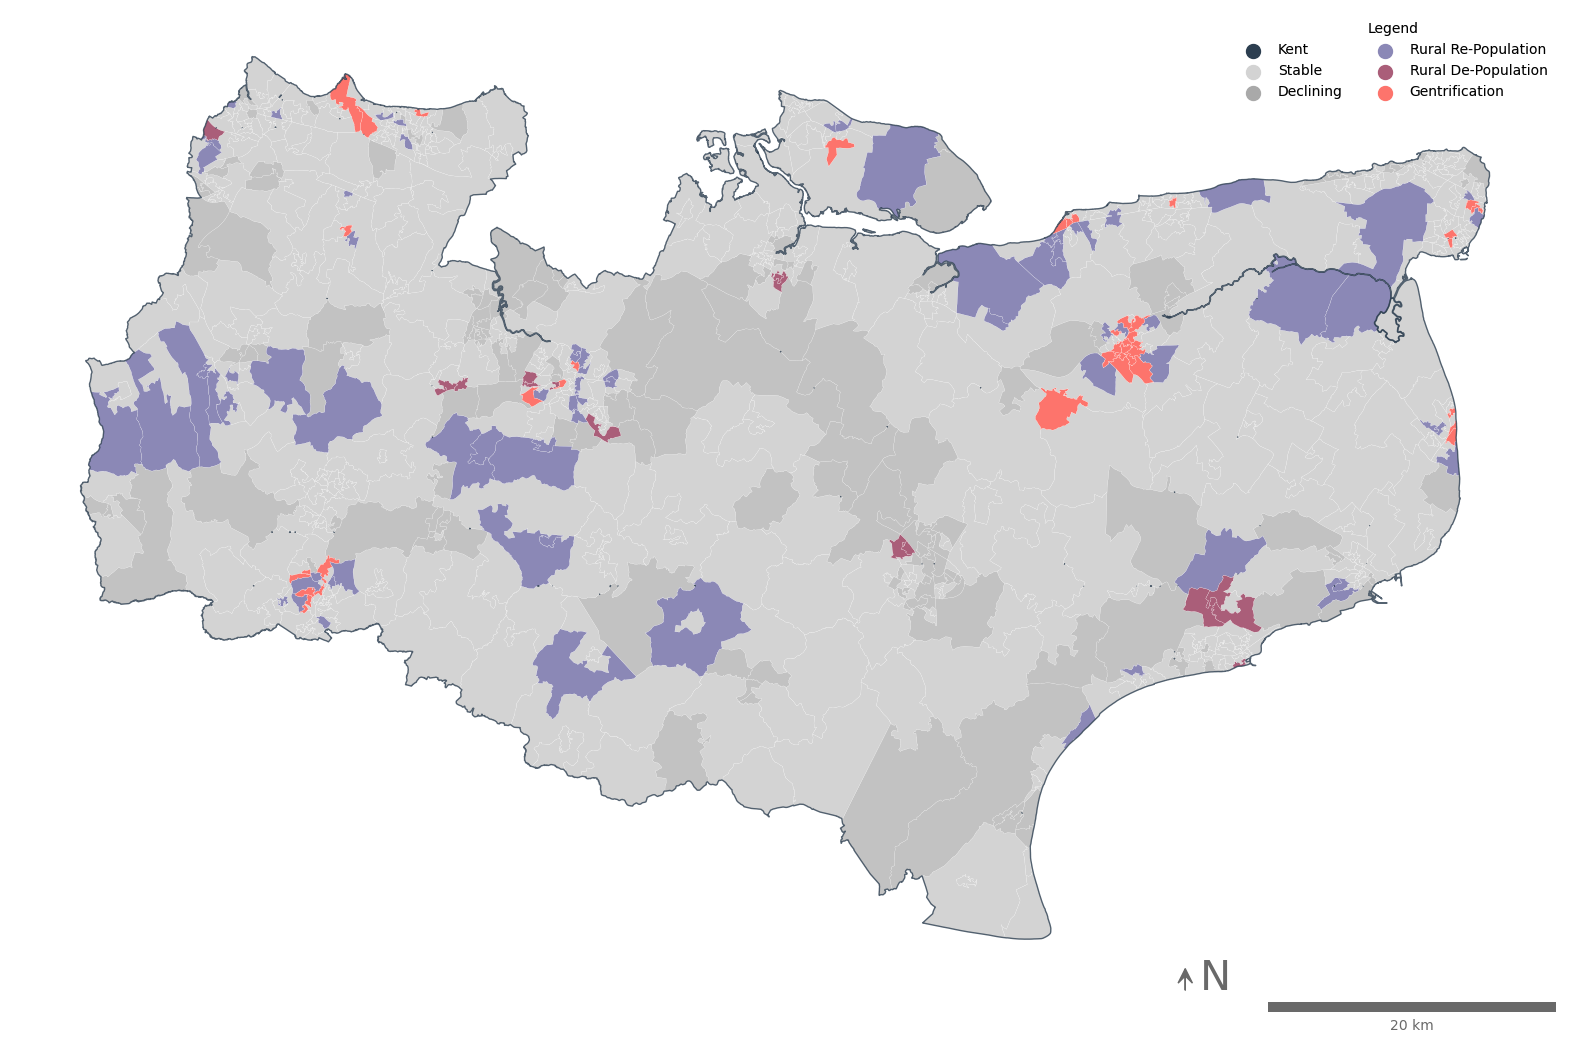

In [187]:
# Filter by status, allowing control over colors of map
stb = level1.loc[level1['Level1Cat'] == "STB"]
dec = level1.loc[level1['Level1Cat'] == "DEC"]
clus1 = cluster_1_yJ_decile_cat_gdf.loc[cluster_1_yJ_decile_cat_gdf['cluster_1_yJ_decile_cat'] == "cluster1"]
clus2 = cluster_1_yJ_decile_cat_gdf.loc[cluster_1_yJ_decile_cat_gdf['cluster_1_yJ_decile_cat'] == "cluster2"]
clus3 = cluster_1_yJ_decile_cat_gdf.loc[cluster_1_yJ_decile_cat_gdf['cluster_1_yJ_decile_cat'] == "cluster3"]

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
level1.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

stb.plot(ax=ax, facecolor="lightgrey")
dec.plot(ax=ax, facecolor="darkgrey", alpha=0.7)
clus1.plot(ax=ax, facecolor="#8B88B6")
clus2.plot(ax=ax, facecolor="#AA5E79")
clus3.plot(ax=ax, facecolor="#fd746c")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='darkgrey')
l4 = plt.scatter([],[], s=100, marker='o', color='#8B88B6')
l5 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')
l6 = plt.scatter([],[], s=100, marker='o', color='#fd746c')

labels = ["Kent", "Stable","Declining", "Rural Re-Population", "Rural De-Population", "Gentrification"]
legend = ax.legend([l1, l2,l3, l4, l5, l6], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()


# 8. Case Studies

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


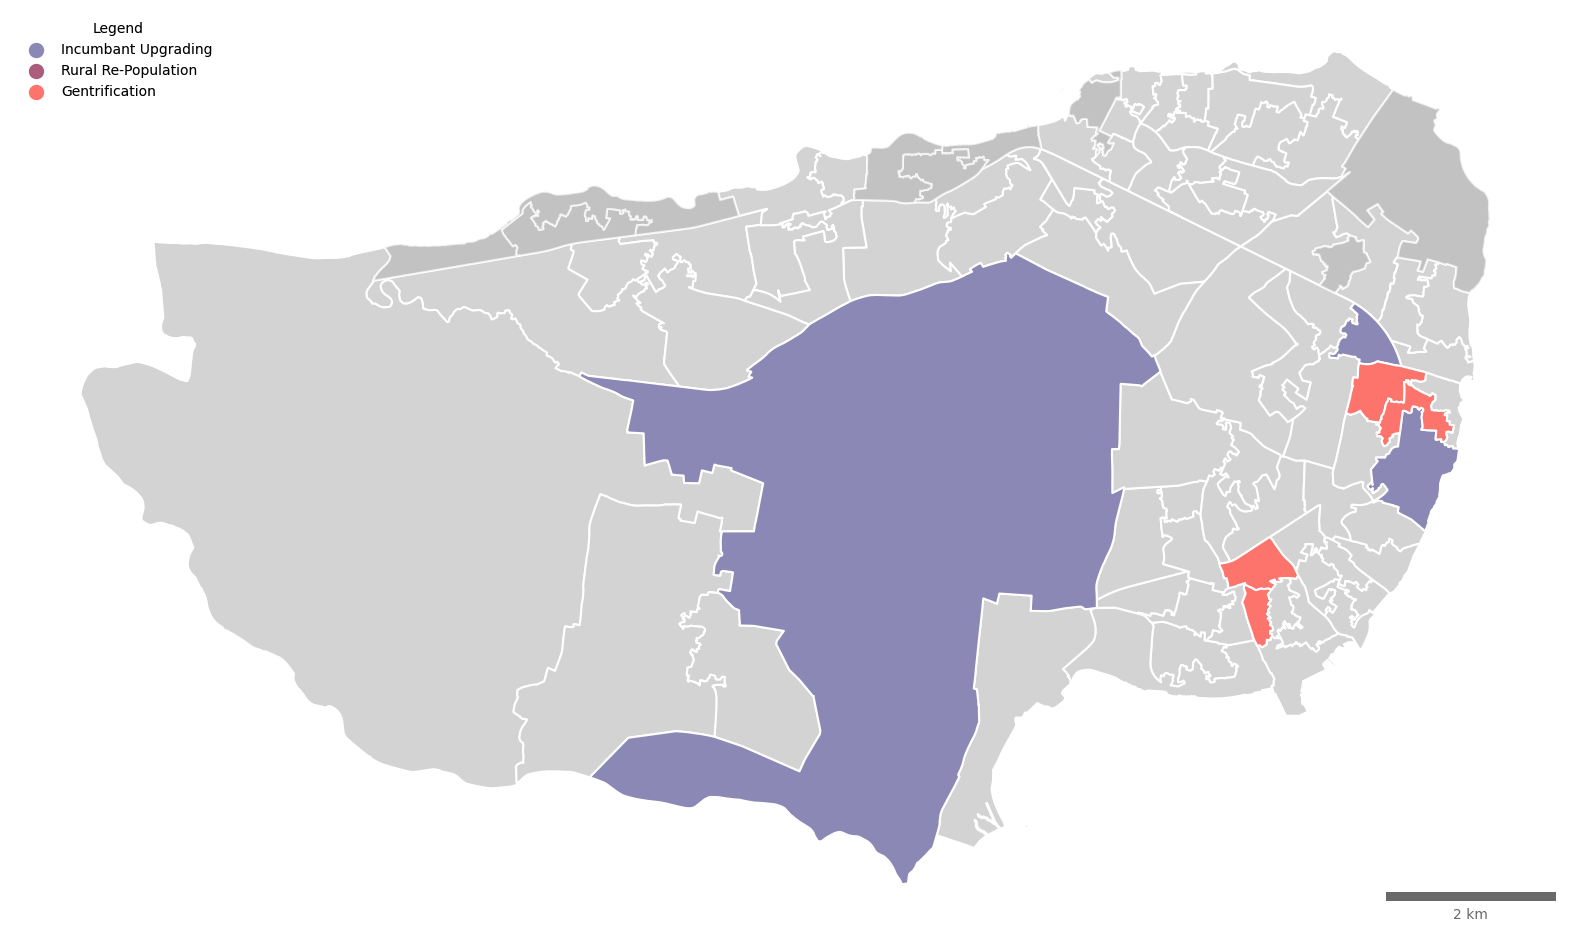

In [189]:
# Thanet

thanet = level1[level1['LSOA11NM'].str.contains("Thanet")]
thanet_level2 = cluster_1_yJ_decile_cat_gdf[cluster_1_yJ_decile_cat_gdf['LSOA11NM'].str.contains("Thanet")]

# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
stb = thanet.loc[thanet['Level1Cat'] == "STB"]
dec = thanet.loc[thanet['Level1Cat'] == "DEC"]
clus1 = thanet_level2.loc[thanet_level2['cluster_1_yJ_decile_cat'] == "cluster1"]
clus2 = thanet_level2.loc[thanet_level2['cluster_1_yJ_decile_cat'] == "cluster2"]
clus3 = thanet_level2.loc[thanet_level2['cluster_1_yJ_decile_cat'] == "cluster3"]


# Plot shapfiles

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")


ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#df_score.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2018.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

#ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
#ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

stb.plot(ax=ax, facecolor="lightgrey", edgecolor="white", linewidth=1.5)
dec.plot(ax=ax, facecolor="darkgrey", alpha=0.7, edgecolor="white", linewidth=1.5)
clus1.plot(ax=ax, facecolor="#8B88B6", edgecolor="white", linewidth=1.5)
clus2.plot(ax=ax, facecolor="#AA5E79", edgecolor="white", linewidth=1.5)
clus3.plot(ax=ax, facecolor="#fd746c", edgecolor="white", linewidth=1.5)

# Add legend
# l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
# l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
# l3 = plt.scatter([],[], s=100, marker='o', color='darkgrey')
l4 = plt.scatter([],[], s=100, marker='o', color='#8B88B6')
l5 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')
l6 = plt.scatter([],[], s=100, marker='o', color='#fd746c')

labels = ["Incumbant Upgrading", "Rural Re-Population", "Gentrification"]
legend = ax.legend([l4, l5, l6], labels, loc="upper left", title='Legend', facecolor="white", edgecolor="white", ncol=1)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
plt.savefig(os.path.join("Figures", 'map_thanet_cluster1.png'), transparent=True, dpi=300)

# Show map
plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


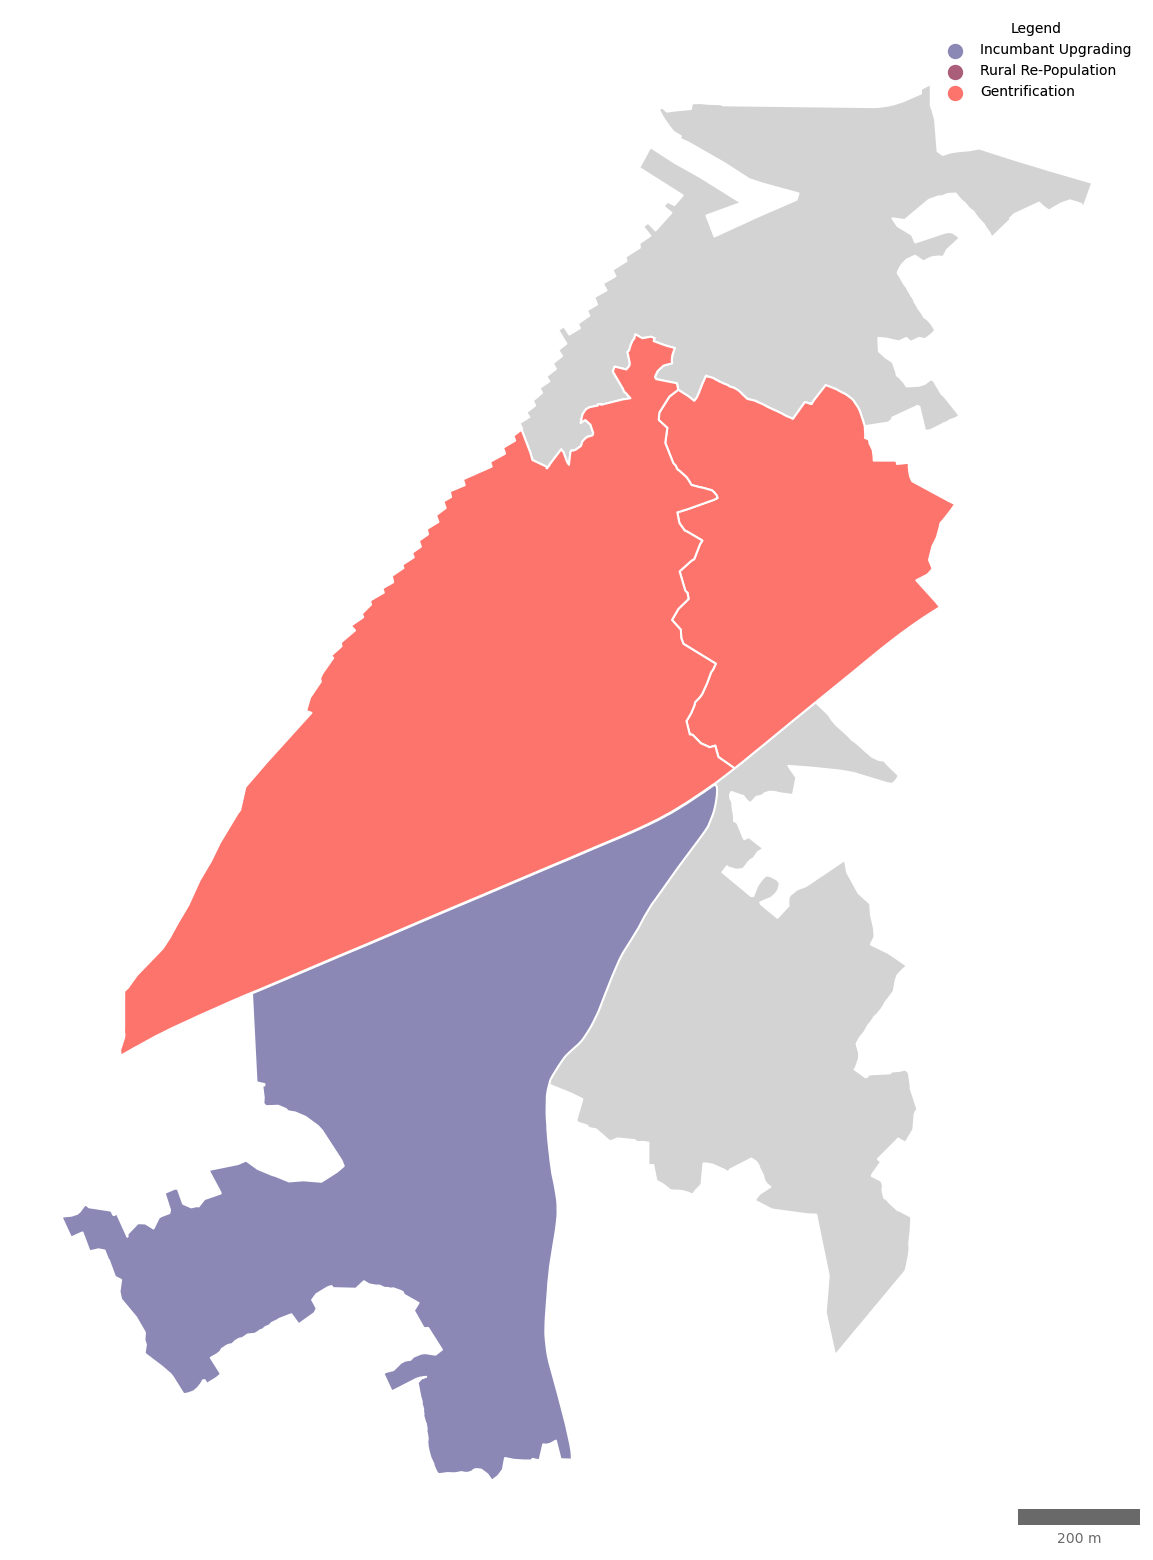

In [149]:
# whitstable

whit = level1[level1['LSOA11NM'].str.contains("Canterbury 008")]
whit_level2 = cluster_1_yJ_decile_cat_gdf[cluster_1_yJ_decile_cat_gdf['LSOA11NM'].str.contains("Canterbury 008")]

# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
stb = whit.loc[whit['Level1Cat'] == "STB"]
dec = whit.loc[whit['Level1Cat'] == "DEC"]
clus1 = whit_level2.loc[whit_level2['cluster_1_yJ_decile_cat'] == "cluster1"]
clus2 = whit_level2.loc[whit_level2['cluster_1_yJ_decile_cat'] == "cluster2"]
clus3 = whit_level2.loc[whit_level2['cluster_1_yJ_decile_cat'] == "cluster3"]


# Plot shapfiles

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")


ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#df_score.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2018.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

#ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
#ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

stb.plot(ax=ax, facecolor="lightgrey", edgecolor="white", linewidth=1.5)
dec.plot(ax=ax, facecolor="darkgrey", alpha=0.7, edgecolor="white", linewidth=1.5)
clus1.plot(ax=ax, facecolor="#8B88B6", edgecolor="white", linewidth=1.5)
clus2.plot(ax=ax, facecolor="#AA5E79", edgecolor="white", linewidth=1.5)
clus3.plot(ax=ax, facecolor="#fd746c", edgecolor="white", linewidth=1.5)

# Add legend
l4 = plt.scatter([],[], s=100, marker='o', color='#8B88B6')
l5 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')
l6 = plt.scatter([],[], s=100, marker='o', color='#fd746c')

labels = ["Incumbant Upgrading", "Rural Re-Population", "Gentrification"]
legend = ax.legend([l4, l5, l6], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=1)    
ax.add_artist(legend)


# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
plt.savefig(os.path.join("Figures", 'map_whistable_cluster1.png'), transparent=True, dpi=300)

# Show map
plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


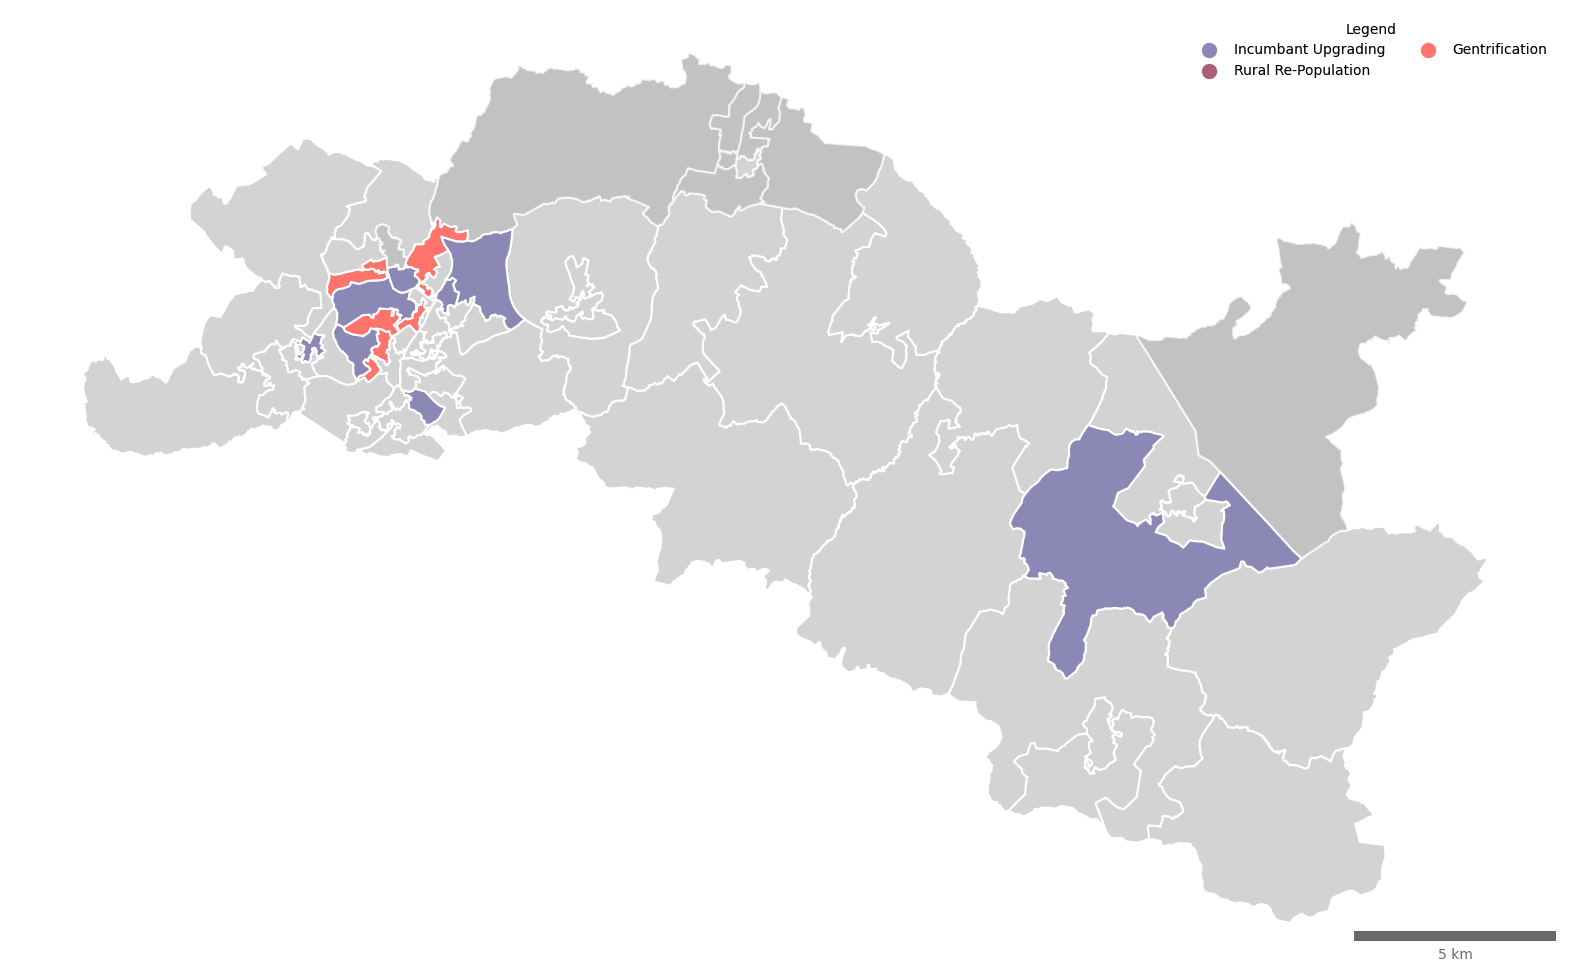

In [150]:
# Tunbridge Wells 

tun = level1[level1['LSOA11NM'].str.contains("Tunbridge Wells")]
tun_level2 = cluster_1_yJ_decile_cat_gdf[cluster_1_yJ_decile_cat_gdf['LSOA11NM'].str.contains("Tunbridge Wells")]

# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
stb = tun.loc[tun['Level1Cat'] == "STB"]
dec = tun.loc[tun['Level1Cat'] == "DEC"]
clus1 = tun_level2.loc[tun_level2['cluster_1_yJ_decile_cat'] == "cluster1"]
clus2 = tun_level2.loc[tun_level2['cluster_1_yJ_decile_cat'] == "cluster2"]
clus3 = tun_level2.loc[tun_level2['cluster_1_yJ_decile_cat'] == "cluster3"]


# Plot shapfiles

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")


ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#df_score.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2018.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

#ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
#ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

stb.plot(ax=ax, facecolor="lightgrey", edgecolor="white", linewidth=1.5)
dec.plot(ax=ax, facecolor="darkgrey", alpha=0.7, edgecolor="white", linewidth=1.5)
clus1.plot(ax=ax, facecolor="#8B88B6", edgecolor="white", linewidth=1.5)
clus2.plot(ax=ax, facecolor="#AA5E79", edgecolor="white", linewidth=1.5)
clus3.plot(ax=ax, facecolor="#fd746c", edgecolor="white", linewidth=1.5)

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='darkgrey')
l4 = plt.scatter([],[], s=100, marker='o', color='#8B88B6')
l5 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')
l6 = plt.scatter([],[], s=100, marker='o', color='#fd746c')

labels = ["Incumbant Upgrading", "Rural Re-Population", "Gentrification"]
legend = ax.legend([l4, l5, l6], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

plt.savefig(os.path.join("Figures", 'map_tunbridge_cluster1.png'), transparent=True, dpi=300)

# Show map
plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


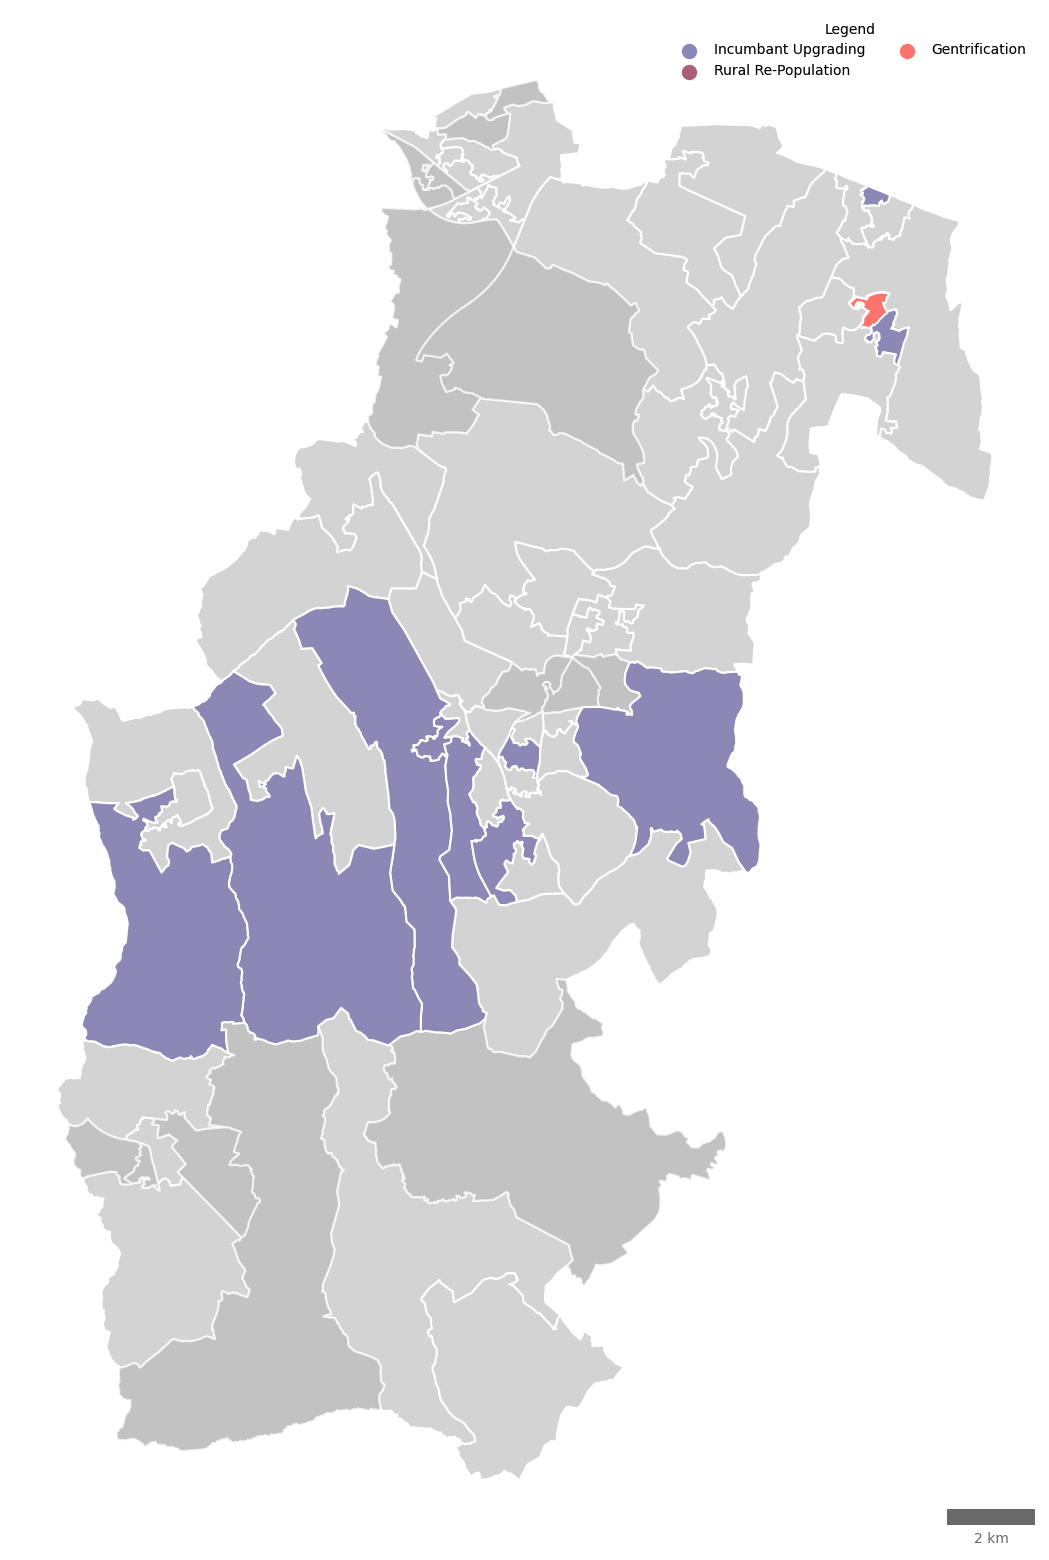

In [151]:
# Sevenoaks 

sev = level1[level1['LSOA11NM'].str.contains("Sevenoaks")]
sev_level2 = cluster_1_yJ_decile_cat_gdf[cluster_1_yJ_decile_cat_gdf['LSOA11NM'].str.contains("Sevenoaks")]

# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
stb = sev.loc[sev['Level1Cat'] == "STB"]
dec = sev.loc[sev['Level1Cat'] == "DEC"]
clus1 = sev_level2.loc[sev_level2['cluster_1_yJ_decile_cat'] == "cluster1"]
clus2 = sev_level2.loc[sev_level2['cluster_1_yJ_decile_cat'] == "cluster2"]
clus3 = sev_level2.loc[sev_level2['cluster_1_yJ_decile_cat'] == "cluster3"]


# Plot shapfiles

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")


ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#df_score.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2018.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

#ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
#ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

stb.plot(ax=ax, facecolor="lightgrey", edgecolor="white", linewidth=1.5)
dec.plot(ax=ax, facecolor="darkgrey", alpha=0.7, edgecolor="white", linewidth=1.5)
clus1.plot(ax=ax, facecolor="#8B88B6", edgecolor="white", linewidth=1.5)
clus2.plot(ax=ax, facecolor="#AA5E79", edgecolor="white", linewidth=1.5)
clus3.plot(ax=ax, facecolor="#fd746c", edgecolor="white", linewidth=1.5)

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='darkgrey')
l4 = plt.scatter([],[], s=100, marker='o', color='#8B88B6')
l5 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')
l6 = plt.scatter([],[], s=100, marker='o', color='#fd746c')

labels = ["Incumbant Upgrading", "Rural Re-Population", "Gentrification"]
legend = ax.legend([l4, l5, l6], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)
   
plt.savefig(os.path.join("Figures", 'map_seven_cluster1.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 9. Clean and Save

In [152]:
# Filter

cluster_1_yJ_decile_cat_gdf_filt = cluster_1_yJ_decile_cat_gdf[["LSOA11CD", "cluster_1_yJ_decile_cat"]]
cluster_1_yJ_decile_cat_gdf_filt = cluster_1_yJ_decile_cat_gdf_filt.rename(columns={"cluster_1_yJ_decile_cat":"Level2Cat"})


In [153]:
# Merge

level1_level2 = pd.merge(level1, cluster_1_yJ_decile_cat_gdf_filt, on="LSOA11CD", how="outer")

In [154]:
# Fix cats

for i in range(len(level1_level2)):
    if level1_level2.loc[i, "Level1Cat"]=="DEC":
        level1_level2.loc[i, "Level2Cat"]="DEC"
    if level1_level2.loc[i, "Level1Cat"]=="STB":
        level1_level2.loc[i, "Level2Cat"]="STB"


In [155]:
level1_level2.to_csv(os.path.join(clean, "gencluster1.csv"))
level1_level2.to_file(os.path.join(clean, "gencluster1.shp"))